<a href="https://colab.research.google.com/github/hfernandescfc/Bitcasting/blob/main/Techinical_crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: importar google drive

from google.colab import drive
drive.mount('/content/drive')

# prompt: display files on drive/mydrive/dissertação/csvs

!ls /content/drive/MyDrive/Dissertação/CSvs

Mounted at /content/drive
Binance_ADAUSDT_d.csv	Binance_ETHUSDT_d.csv	 Binance_XRPUSDT_d.csv	  model_outputs_hist.pkl
Binance_AVAXUSDT_d.csv	Binance_MATICUSDT_d.csv  loaded_files.pkl	  model_outputs_tech.pkl
Binance_BTCUSDT_d.csv	Binance_SOLUSDT_d.csv	 model_outputs_block.pkl


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import os
dfs = []
for file in os.listdir('/content/drive/MyDrive/Dissertação/CSvs'):
  if file.endswith(".csv"):
    df = pd.read_csv(os.path.join('/content/drive/MyDrive/Dissertação/CSvs', file), header=1)
    dfs.append(df)


In [3]:
btc_df = dfs[1]

In [4]:
btc_df.Date = pd.to_datetime(btc_df['Date'])

In [5]:
btc_df.set_index('Date', inplace = True)

In [6]:
btc_df.columns

Index(['Unix', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume ETH',
       'Volume USDT', 'tradecount'],
      dtype='object')

In [7]:
btc_df = btc_df[['Open', 'High', 'Low', 'Close', 'Volume USDT']]

btc_df = btc_df.rename(columns={'Volume USDT': 'Volume'})

In [8]:
btc_df = btc_df.sort_index()

In [9]:
btc_df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06
...,...,...,...,...,...
2024-02-29,3383.11,3522.81,3300.00,3340.09,2.608623e+09
2024-03-01,3340.10,3450.00,3338.54,3433.43,1.405296e+09
2024-03-02,3433.42,3460.04,3390.01,3421.40,9.717569e+08


In [10]:
def calculate_moving_average(df, column, window):
    """
    Calculate the moving average for a specified column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame
    column (str): The name of the column to calculate the moving average for
    window (int): The size of the moving window

    Returns:
    pandas.Series: The calculated moving average
    """
    return df[column].rolling(window=window).mean()

windows = [3, 5, 7, 20, 50, 100]

for window in windows:
    btc_df[f'MA_{window}'] = calculate_moving_average(btc_df, 'Close', window)

In [11]:
def calculate_exponential_moving_average(df, column, span):
    """
    Calculate the exponential moving average for a specified column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame
    column (str): The name of the column to calculate the exponential moving average for
    span (int): The span for the EMA calculation

    Returns:
    pandas.Series: The calculated exponential moving average
    """
    return df[column].ewm(span=span, adjust=False, min_periods = span).mean()


spans = [3, 5, 7, 20, 50, 100]

for span in spans:
    btc_df[f'EMA_{span}'] = calculate_exponential_moving_average(btc_df, 'Close', span)

In [12]:
def calculate_rsi(data, window):
    # Calculate the price changes
    delta = data['Close'].diff()

    # Separate the positive and negative gains
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    # Calculate the average gains and losses
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI with a window size of 14 (common period)
btc_df['RSI_14'] = calculate_rsi(btc_df, 14)

In [13]:
def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper_Band'] = data['SMA'] + (data['STD'] * num_std_dev)
    data['Lower_Band'] = data['SMA'] - (data['STD'] * num_std_dev)
    return data

btc_df = calculate_bollinger_bands(btc_df)

In [14]:
def calculate_obv(data):
    data['Change'] = data['Close'].diff()
    data['Direction'] = data['Change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    data['OBV'] = (data['Direction'] * data['Volume']).cumsum()
    return data

# Calculate OBV
btc_df = calculate_obv(btc_df)

In [15]:
def calculate_pivot_points(data):
    pivot_points = pd.DataFrame(index=data.index, columns=['Pivot', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3'])
    pivot_points['Pivot'] = (data['High'].shift(1) + data['Low'].shift(1) + data['Close'].shift(1)) / 3
    pivot_points['R1'] = 2 * pivot_points['Pivot'] - data['Low'].shift(1)
    pivot_points['S1'] = 2 * pivot_points['Pivot'] - data['High'].shift(1)
    pivot_points['R2'] = pivot_points['Pivot'] + (data['High'].shift(1) - data['Low'].shift(1))
    pivot_points['S2'] = pivot_points['Pivot'] - (data['High'].shift(1) - data['Low'].shift(1))
    pivot_points['R3'] = pivot_points['R2'] + (data['High'].shift(1) - data['Low'].shift(1))
    pivot_points['S3'] = pivot_points['S2'] - (data['High'].shift(1) - data['Low'].shift(1))
    return pivot_points

# Calculate Pivot Points
pivot_points = calculate_pivot_points(btc_df)

btc_df = btc_df.join(pivot_points)

In [16]:
btc_df['Close_t+1'] = btc_df['Close'].shift(-1)

btc_df['Direction_t+1'] = np.where(btc_df['Close_t+1'] > btc_df['Close'], 1, 0)


In [17]:
btc_df['Direction_t+1'].value_counts()

,count
Direction_t+1,
1,1225
0,1167


In [18]:
horizontes = [3,5, 7, 14, 30]

# Função para calcular a direção com base no preço de fechamento
def calcular_direcao(close, periodo):
    return (close.shift(-periodo) > close).astype(int)
    return (close.shift(-periodo))

# Criar colunas de 'Direction_t+n' para cada horizonte desejado
for horizonte in horizontes:
    coluna_direcao = f'Direction_t+{horizonte}'
    btc_df[coluna_direcao] = calcular_direcao(btc_df['Close'], horizonte)
    close_t = f'Close_t+{horizonte}'
    btc_df[close_t] = btc_df['Close'].shift(-horizonte)

In [19]:
btc_df.iloc[:, :20].head(8)

,Open,High,Low,Close,Volume,MA_3,MA_5,MA_7,MA_20,MA_50,MA_100,EMA_3,EMA_5,EMA_7,EMA_20,EMA_50,EMA_100,RSI_14,SMA,STD
Date,,,,,,,,,,,,,,,,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05,295.623333,NaN,NaN,NaN,NaN,NaN,294.445000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05,294.656667,NaN,NaN,NaN,NaN,NaN,296.772500,NaN,NaN,NaN,NaN,NaN,42.479253,NaN,NaN
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06,304.433333,301.852,NaN,NaN,NaN,NaN,310.031250,306.015185,NaN,NaN,NaN,NaN,74.488153,NaN,NaN
2017-08-22,321.04,330.41,144.21,309.80,2.454426e+06,310.730000,303.412,NaN,NaN,NaN,NaN,309.915625,307.276790,NaN,NaN,NaN,NaN,56.846910,NaN,NaN
2017-08-23,312.25,324.99,309.41,315.74,2.753465e+06,316.276667,307.768,304.971429,NaN,NaN,NaN,312.827812,310.097860,308.231328,NaN,NaN,NaN,60.922099,NaN,NaN
2017-08-24,315.74,328.04,314.01,323.42,2.159417e+06,316.320000,314.270,308.031429,NaN,NaN,NaN,318.123906,314.538573,312.028496,NaN,NaN,NaN,65.174270,NaN,NaN


In [20]:
btc_df = btc_df.dropna()

Evaluating model: XGBoost


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


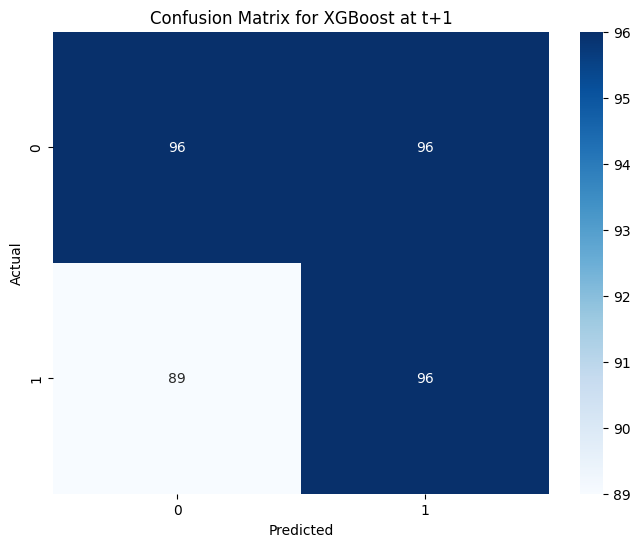

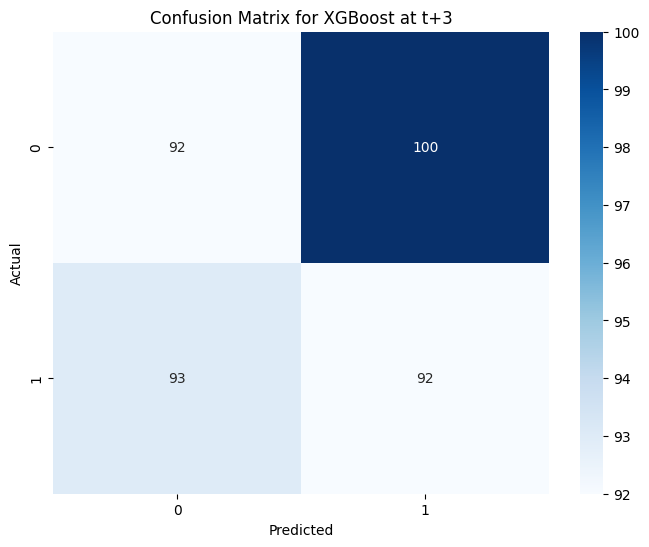

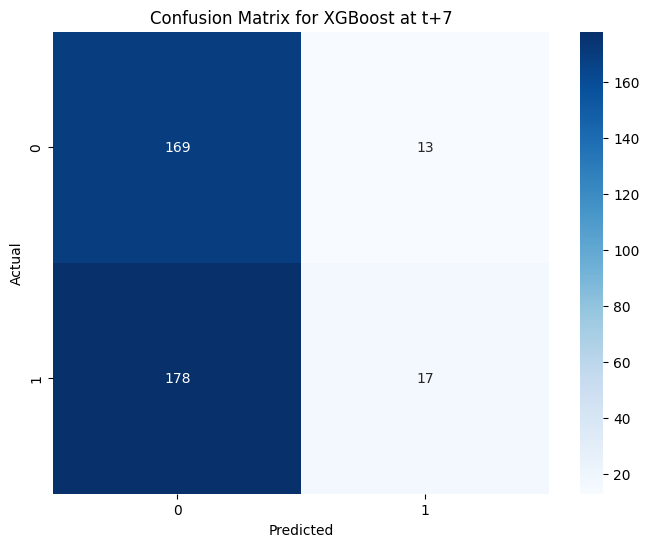

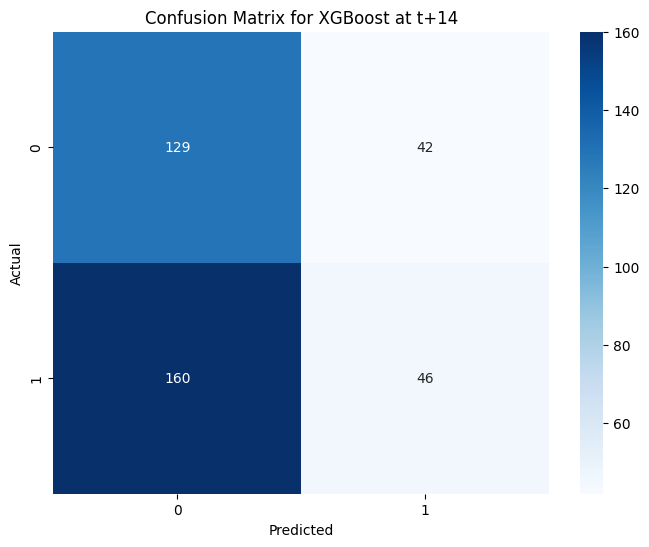

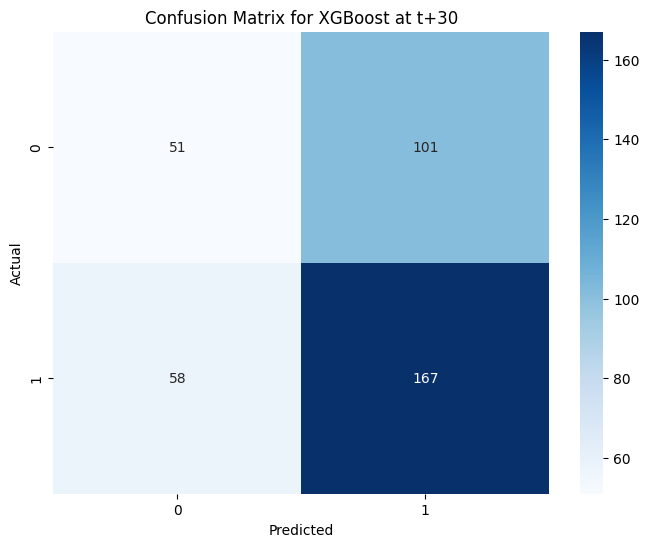

Evaluating model: LightGBM
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 182, number of negative: 196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481481 -> initscore=-0.074108
[LightGBM] [Info] Start training from score -0.074108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

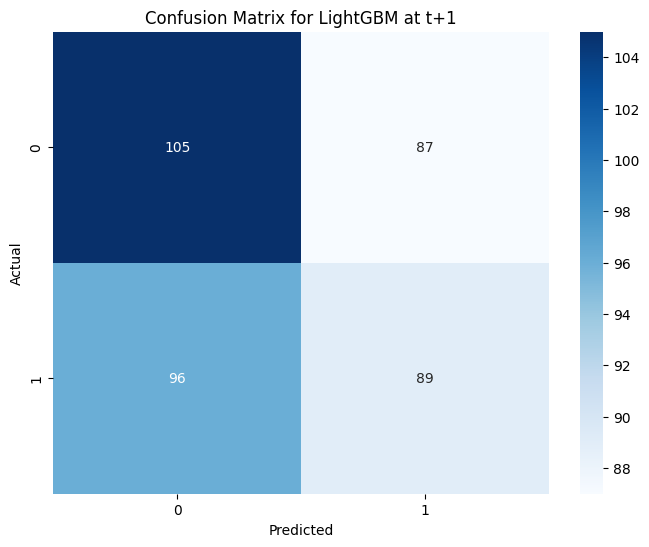

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 174, number of negative: 204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460317 -> initscore=-0.159065
[LightGBM] [Info] Start training from score -0.159065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

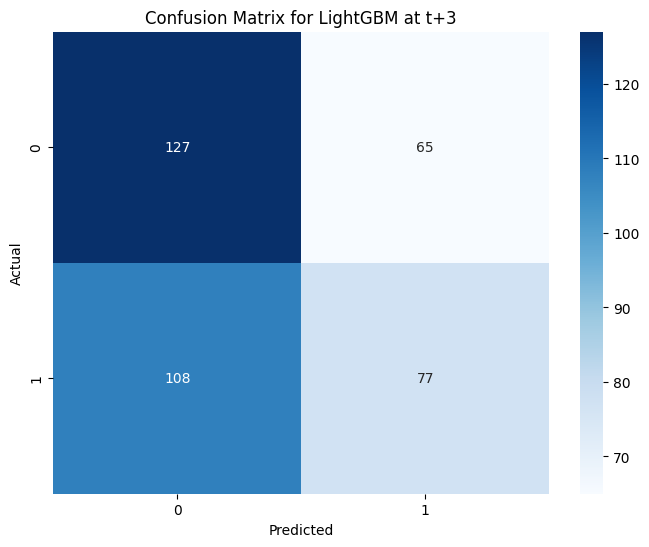

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 154, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.407407 -> initscore=-0.374693
[LightGBM] [Info] Start training from score -0.374693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

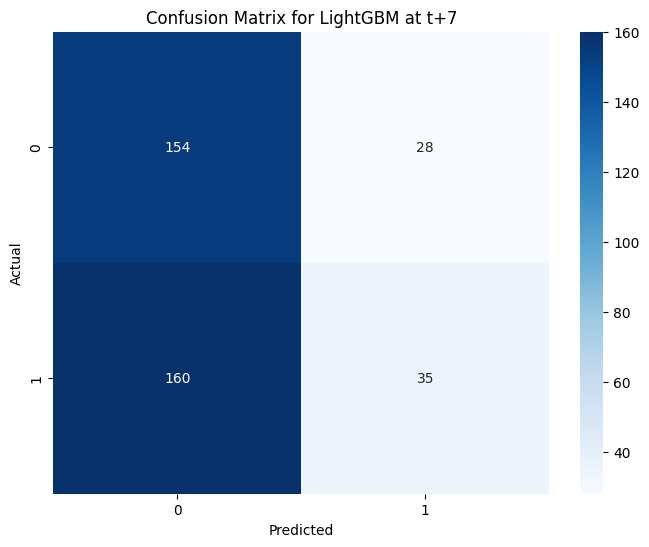

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 145, number of negative: 233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383598 -> initscore=-0.474305
[LightGBM] [Info] Start training from score -0.474305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

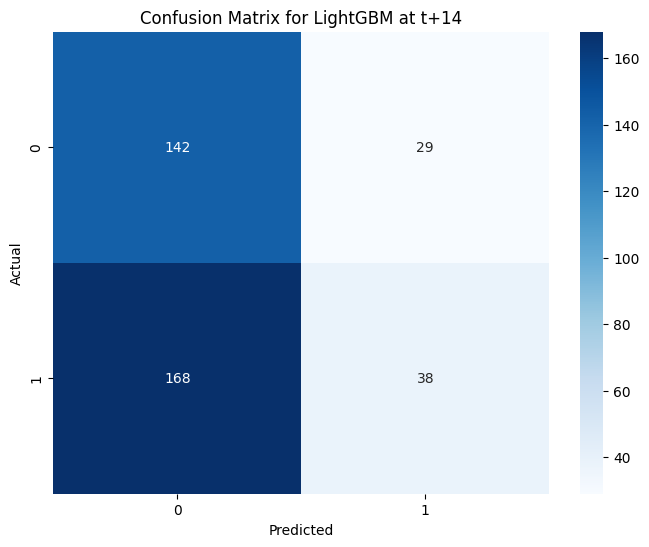

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 109, number of negative: 269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288360 -> initscore=-0.903363
[LightGBM] [Info] Start training from score -0.903363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

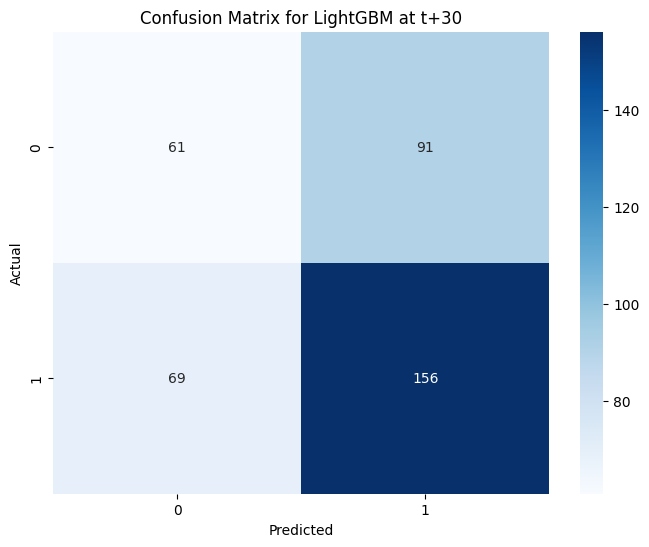

      Model Horizonte  Mean Accuracy  Mean Precision  Mean Recall  \
0   XGBoost       t+1       0.527321        0.550433     0.537731   
1   XGBoost       t+3       0.498674        0.541218     0.420648   
2   XGBoost       t+7       0.510345        0.566579     0.435660   
3   XGBoost      t+14       0.499735        0.540583     0.459679   
4   XGBoost      t+30       0.549072        0.694503     0.683006   
5  LightGBM       t+1       0.541645        0.562597     0.527367   
6  LightGBM       t+3       0.507162        0.504240     0.420644   
7  LightGBM       t+7       0.524138        0.626637     0.449864   
8  LightGBM      t+14       0.516180        0.671334     0.480280   
9  LightGBM      t+30       0.534748        0.672914     0.637313   

   Mean F1 Score  
0       0.515022  
1       0.443678  
2       0.399482  
3       0.428656  
4       0.594239  
5       0.518336  
6       0.430755  
7       0.432923  
8       0.437054  
9       0.586358  


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import Normalizer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# List of forecasting horizons
horizontes = [1, 3, 7, 14, 30]
features = ['High', 'S3', 'Upper_Band', 'Close', 'STD', 'Lower_Band', 'Volume', 'Low', 'OBV', 'MA_50', 'S2', 'R2',
            'Pivot', 'MA_100', 'R3', 'MA_5', 'MA_3', 'MA_7', 'Change', 'Open', 'RSI_14', 'MA_20', 'EMA_3',
            'R1', 'S1', 'EMA_5', 'EMA_7', 'EMA_20', 'EMA_50', 'EMA_100']

# List of models to test
models = {
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, silent= True)
}

# Storage for results
all_results = []

# Initialize the RobustScaler
scaler = Normalizer()

# Loop over each model
for model_name, model_instance in models.items():
    print(f"Evaluating model: {model_name}")

    # Loop over each horizon
    for horizonte in horizontes:
        target_col = f'Direction_t+{horizonte}'

        # Drop NaNs in the current target
        btc_df_h = btc_df.dropna(subset=[target_col])

        # Prepare features and target
        X = btc_df_h[features]
        y = btc_df_h[target_col]

        # Apply RobustScaler to the features
        X_scaled = scaler.fit_transform(X)

        # Initialize TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        # Storage for cross-validation metrics
        metrics = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1 Score': []
        }

        # Perform cross-validation
        for train_index, test_index in tscv.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model
            model = model_instance
            model.fit(X_train, y_train)

            # Predict on test data
            y_pred = model.predict(X_test)

            # Calculate performance metrics
            metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['Precision'].append(precision_score(y_test, y_pred))
            metrics['Recall'].append(recall_score(y_test, y_pred))
            metrics['F1 Score'].append(f1_score(y_test, y_pred))

        # Average metrics for this horizon
        all_results.append({
            'Model': model_name,
            'Horizonte': f't+{horizonte}',
            'Mean Accuracy': np.mean(metrics['Accuracy']),
            'Mean Precision': np.mean(metrics['Precision']),
            'Mean Recall': np.mean(metrics['Recall']),
            'Mean F1 Score': np.mean(metrics['F1 Score'])
        })

        # Plot confusion matrix for last iteration in cross-validation
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name} at t+{horizonte}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Display results as DataFrame for analysis
resultados_df = pd.DataFrame(all_results)
print(resultados_df)


Evaluating model: XGBoost


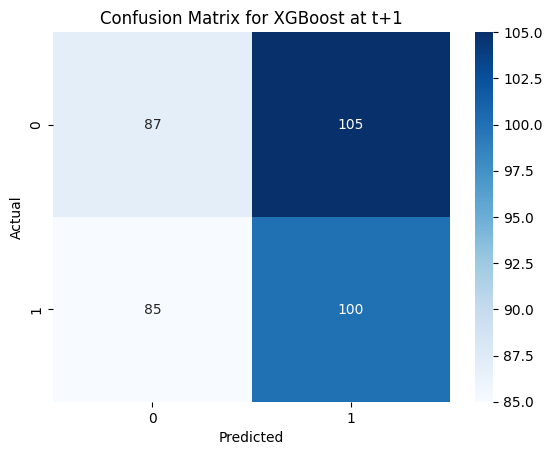

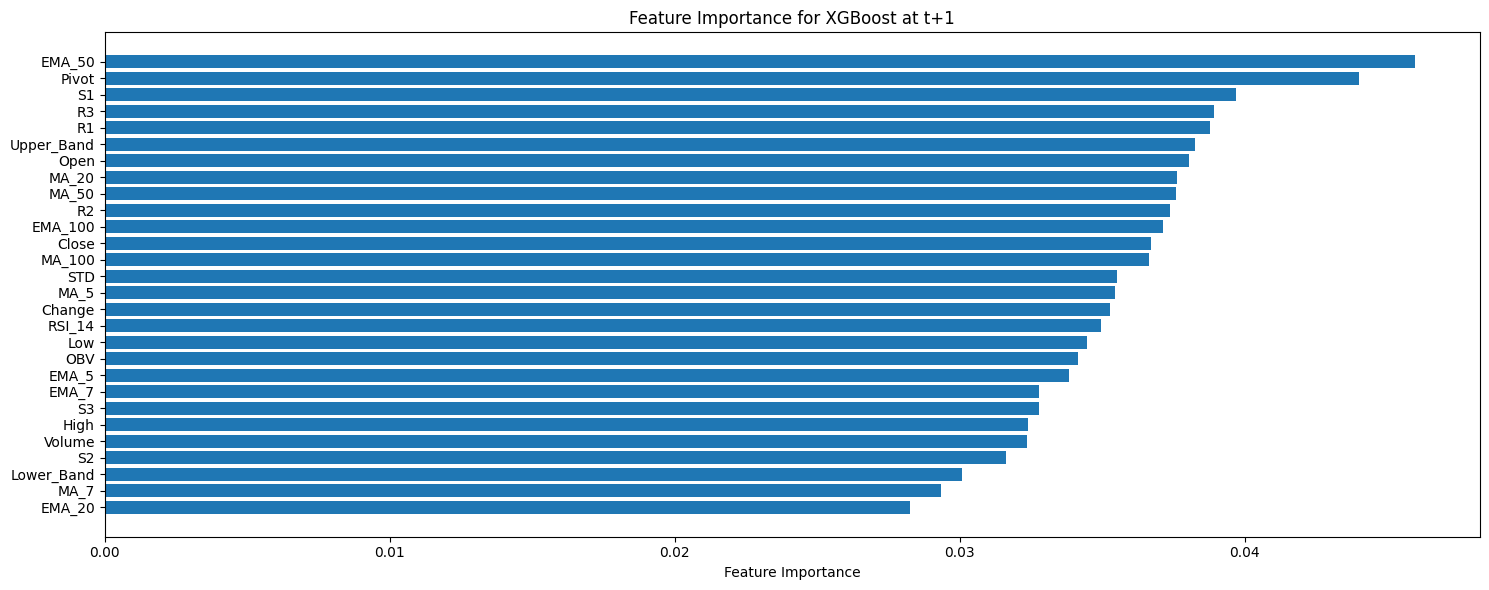

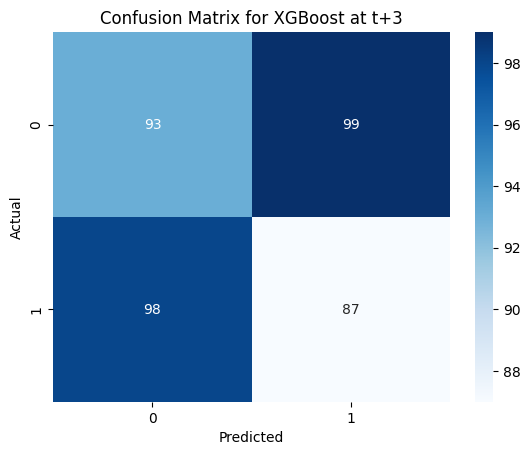

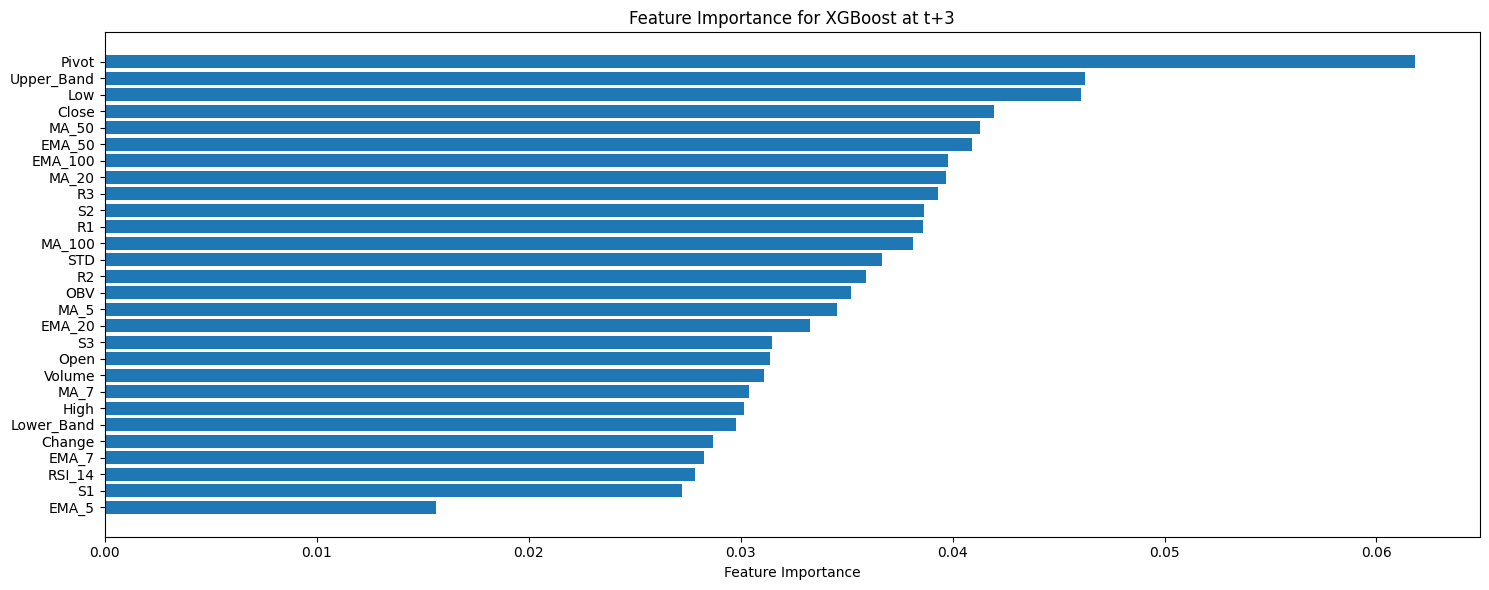

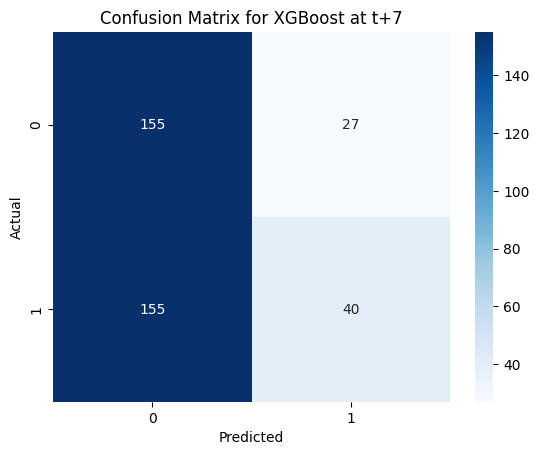

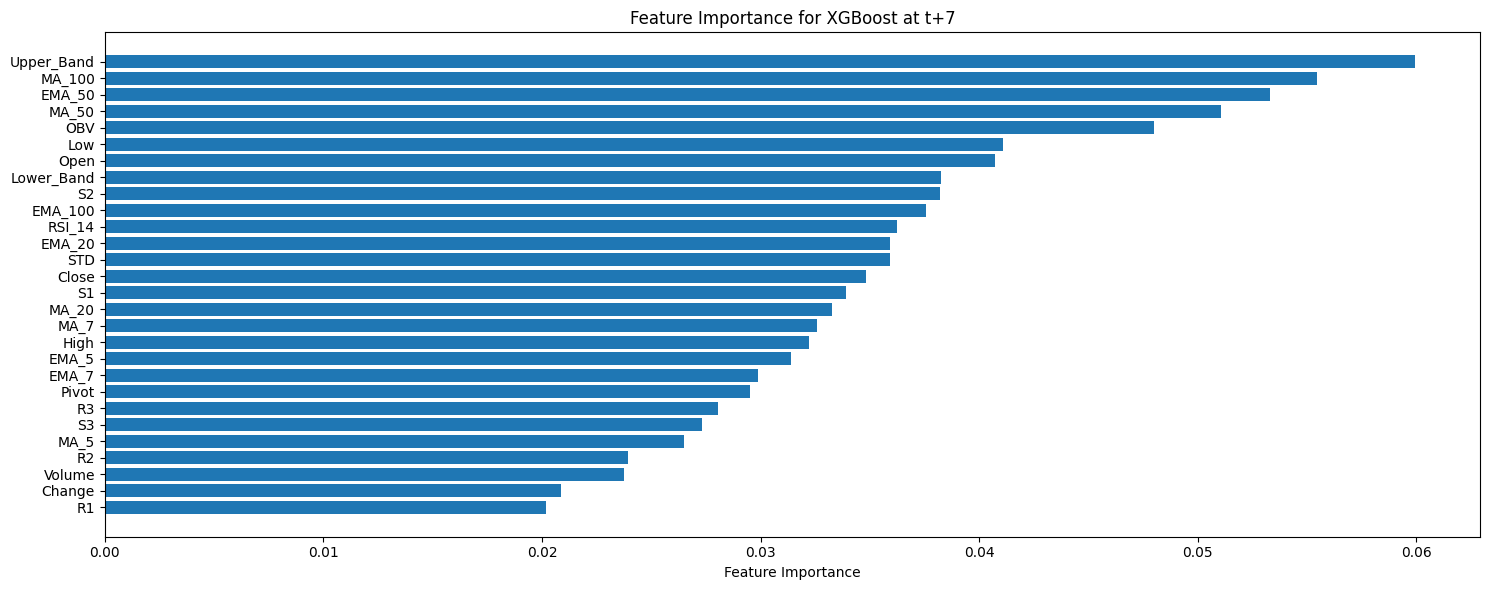

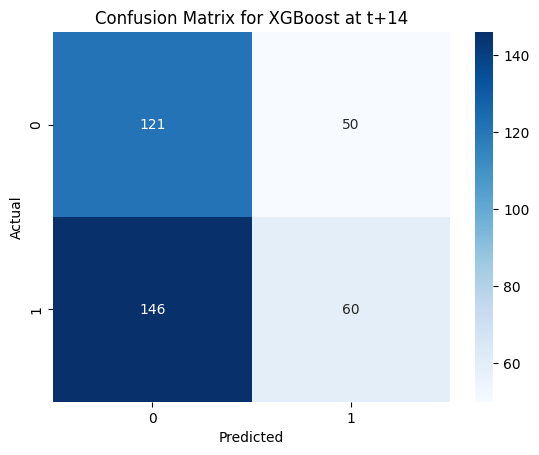

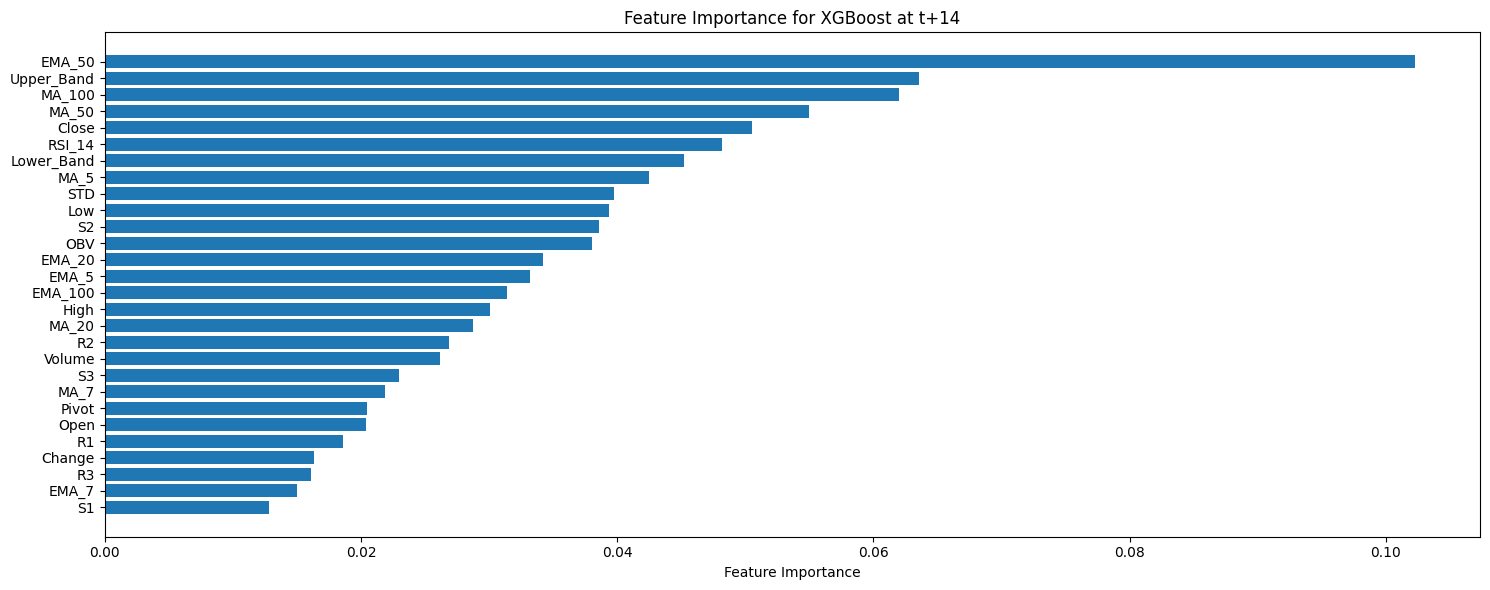

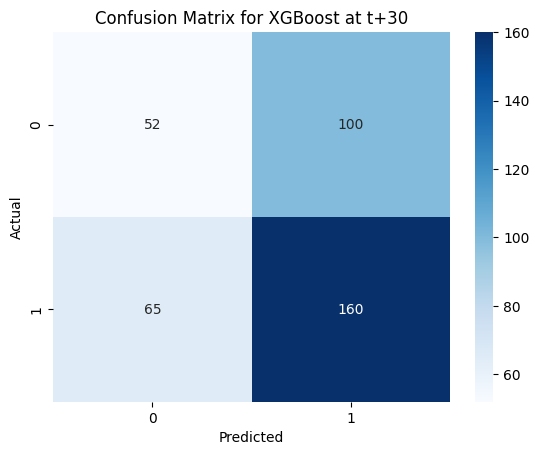

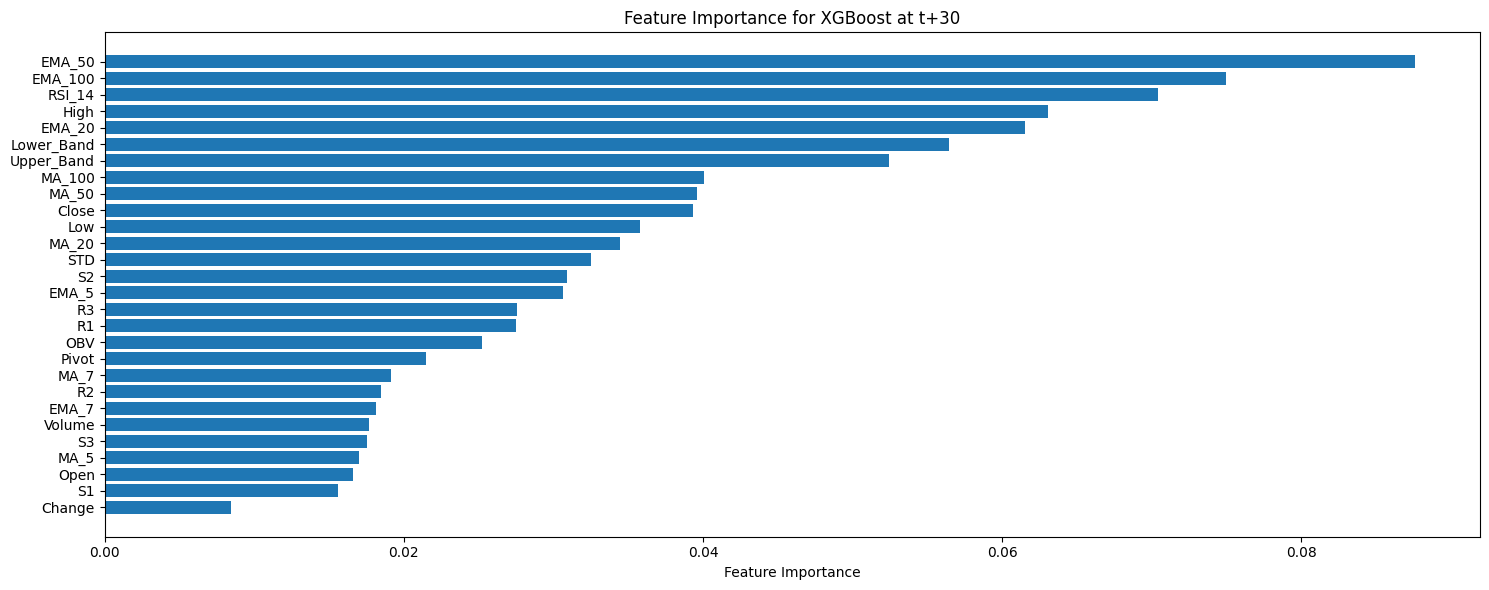

Evaluating model: LightGBM
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 182, number of negative: 196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3556
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481481 -> initscore=-0.074108
[LightGBM] [Info] Start training from score -0.074108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

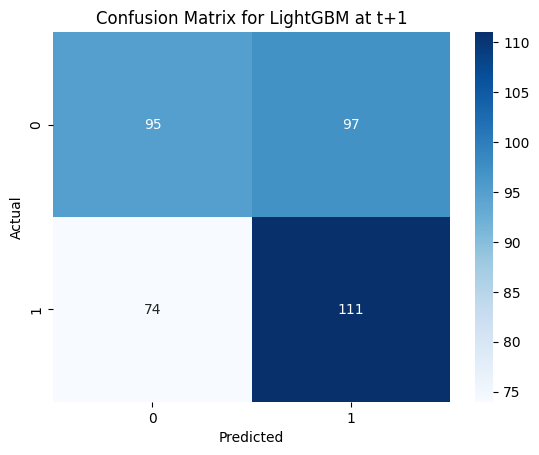

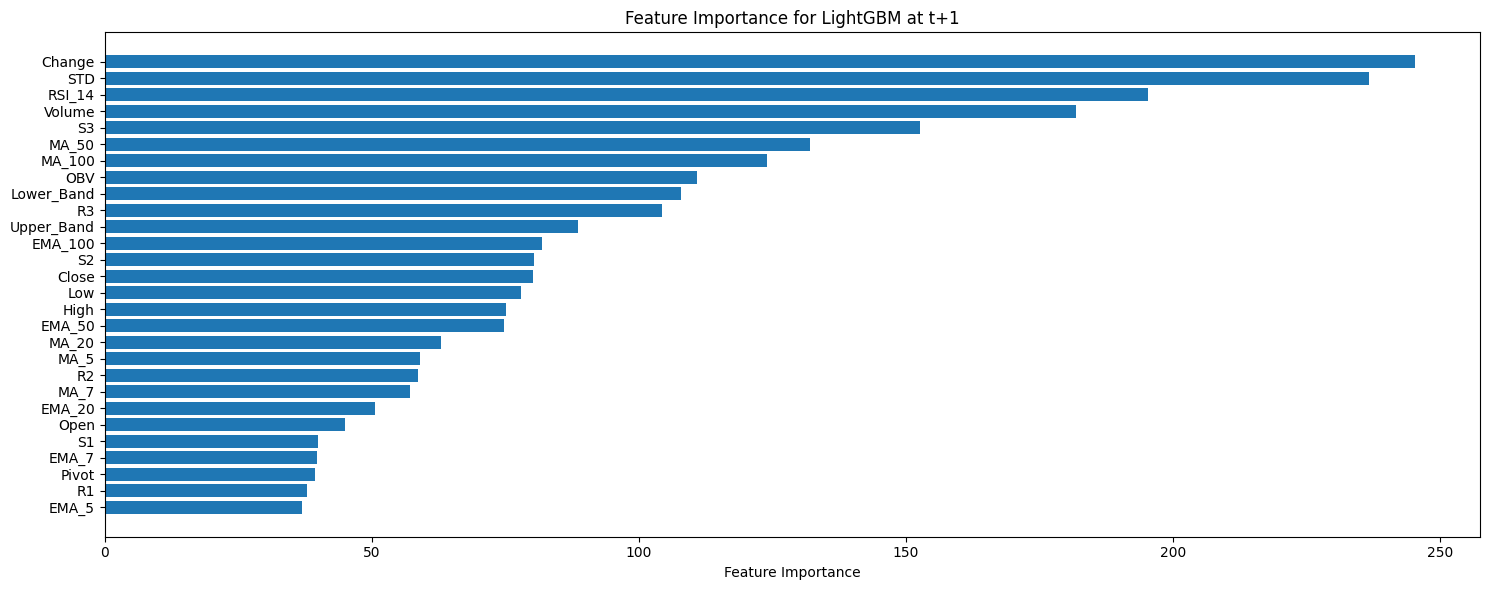

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 174, number of negative: 204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3556
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460317 -> initscore=-0.159065
[LightGBM] [Info] Start training from score -0.159065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

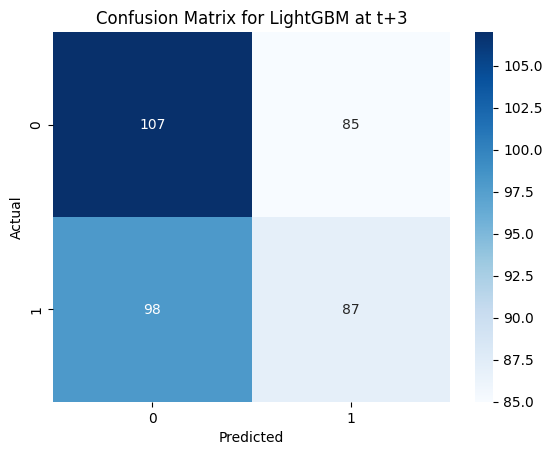

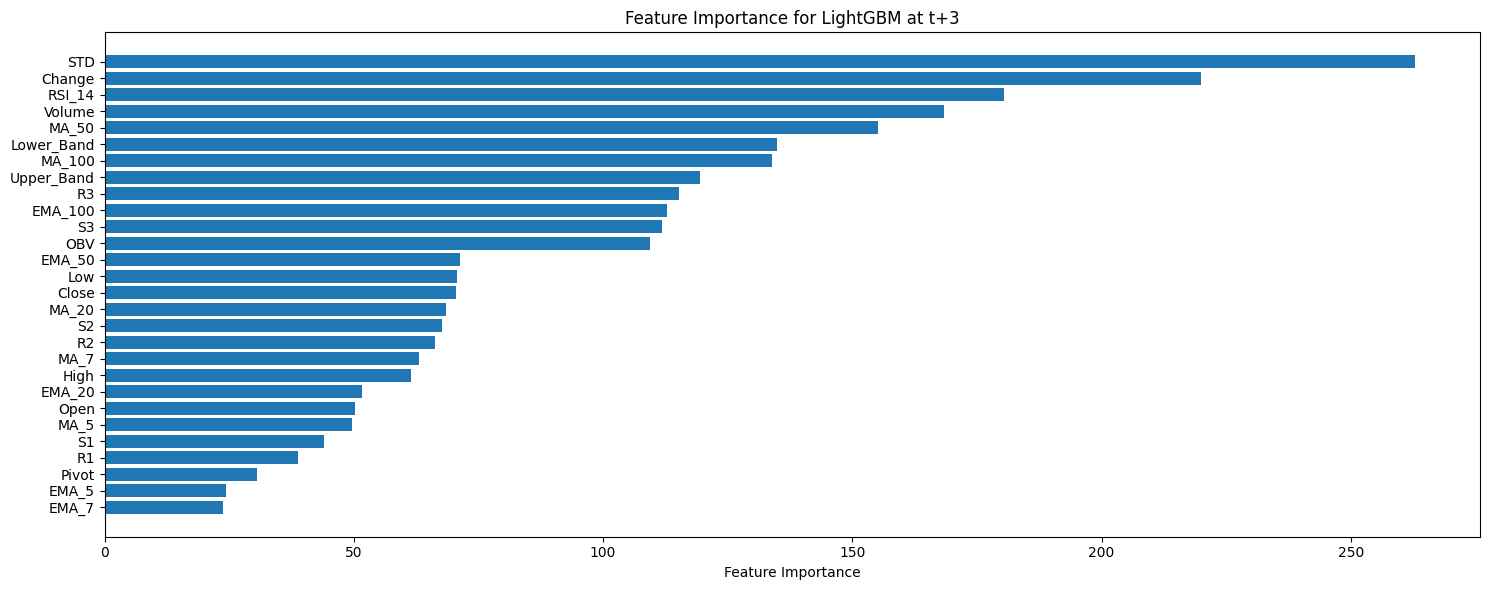

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 154, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3556
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.407407 -> initscore=-0.374693
[LightGBM] [Info] Start training from score -0.374693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

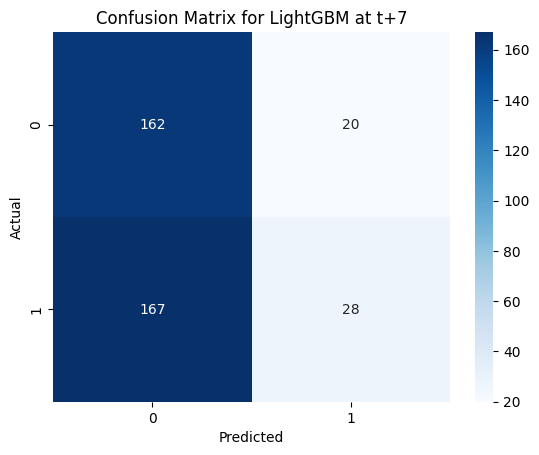

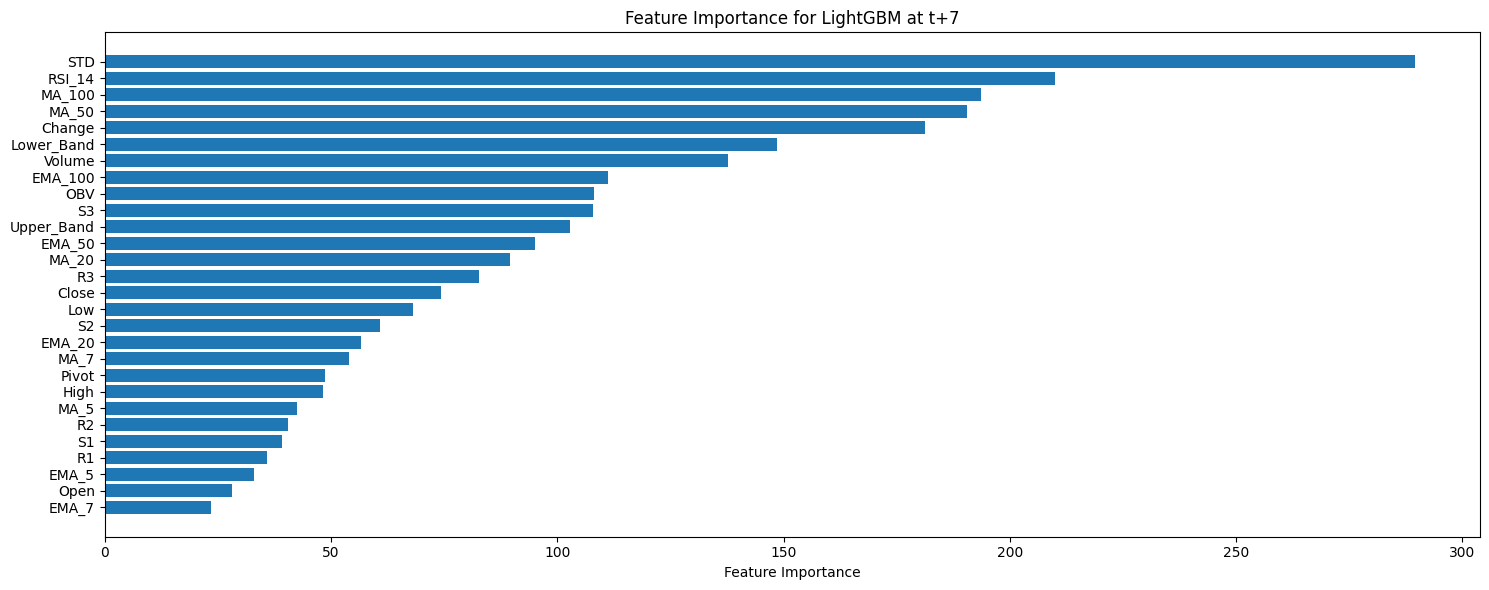

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 145, number of negative: 233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3556
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383598 -> initscore=-0.474305
[LightGBM] [Info] Start training from score -0.474305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

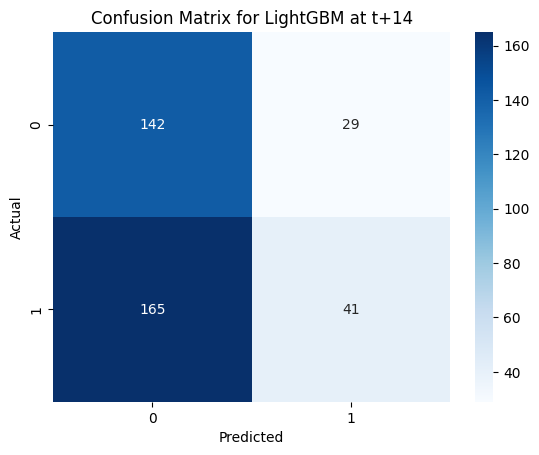

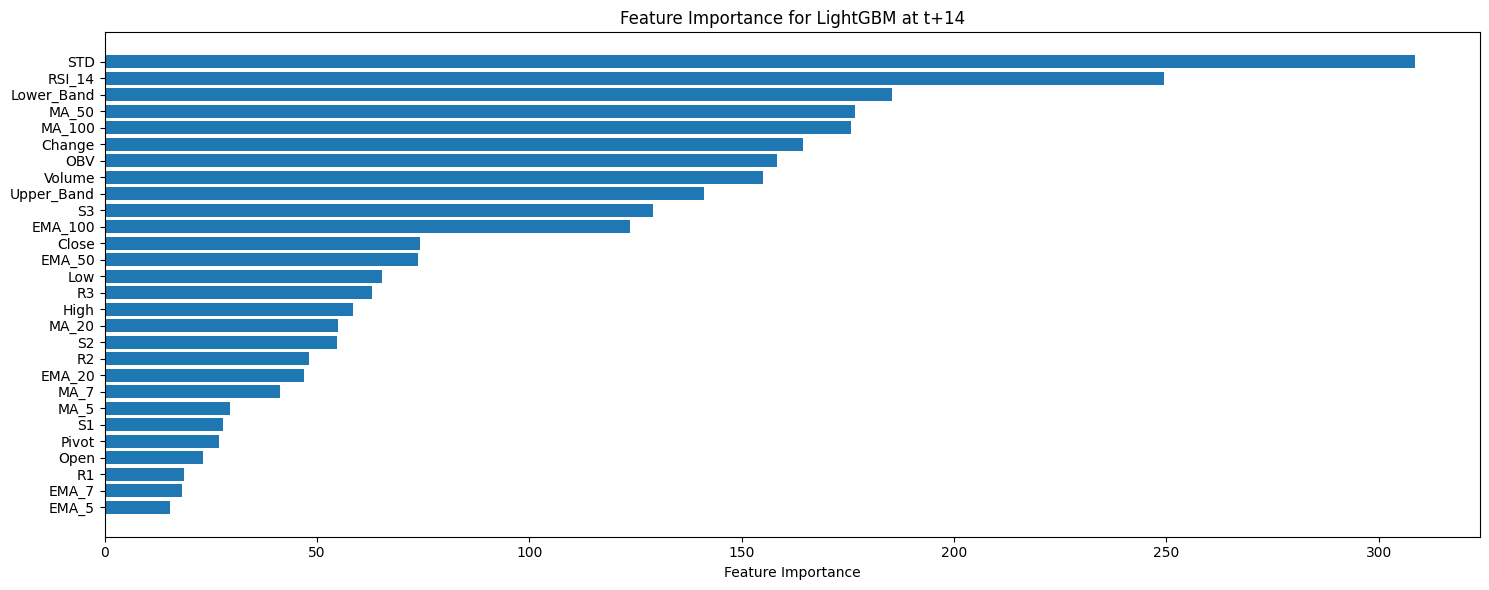

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 109, number of negative: 269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3556
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288360 -> initscore=-0.903363
[LightGBM] [Info] Start training from score -0.903363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

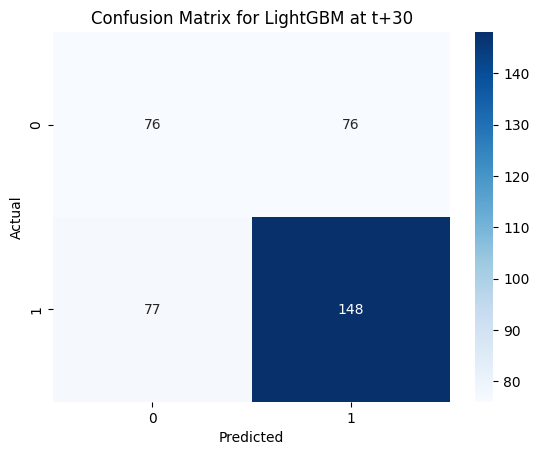

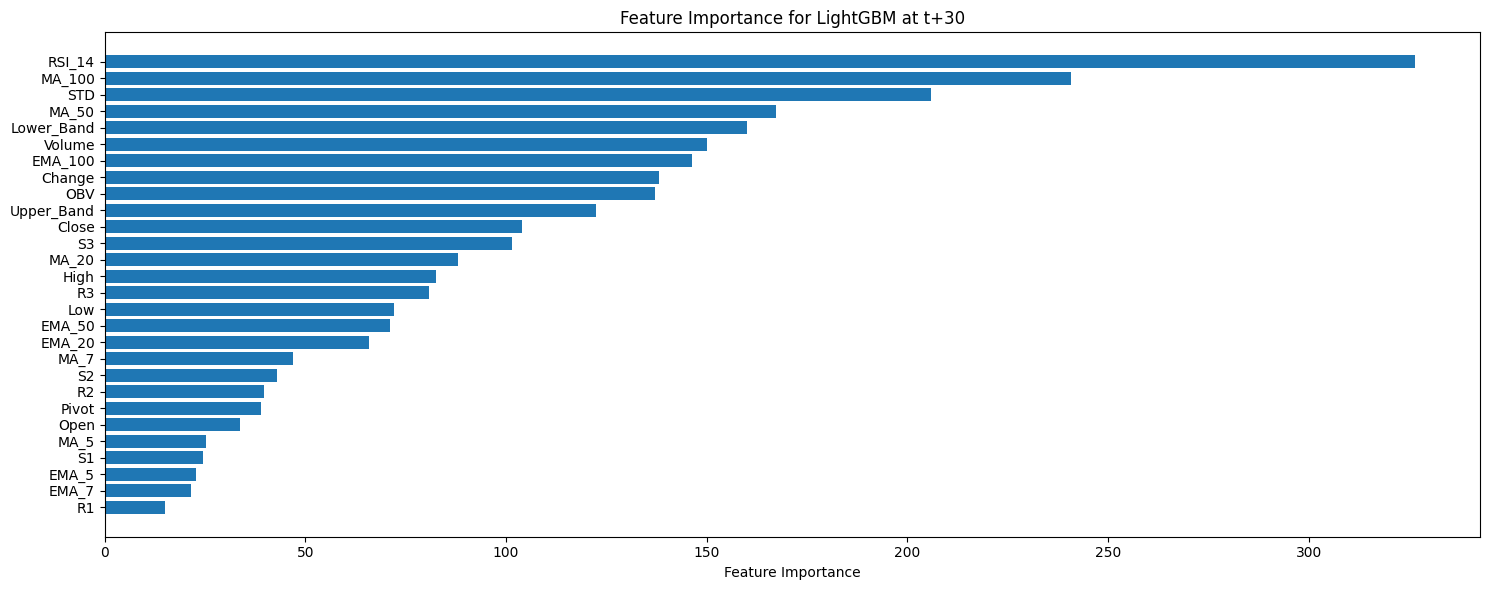

      Model Horizonte  Mean Accuracy  Mean Precision  Mean Recall  \
0   XGBoost       t+1       0.526260        0.547546     0.560316   
1   XGBoost       t+3       0.504509        0.552799     0.433939   
2   XGBoost       t+7       0.524138        0.588471     0.478081   
3   XGBoost      t+14       0.496021        0.556611     0.464303   
4   XGBoost      t+30       0.541114        0.692761     0.668201   
5  LightGBM       t+1       0.550663        0.566276     0.563191   
6  LightGBM       t+3       0.502387        0.513033     0.421571   
7  LightGBM       t+7       0.519894        0.620516     0.434748   
8  LightGBM      t+14       0.512997        0.473342     0.481132   
9  LightGBM      t+30       0.541645        0.676911     0.629250   

   Mean F1 Score  
0       0.527159  
1       0.454494  
2       0.444003  
3       0.432316  
4       0.585676  
5       0.540141  
6       0.431074  
7       0.416111  
8       0.437075  
9       0.587932  


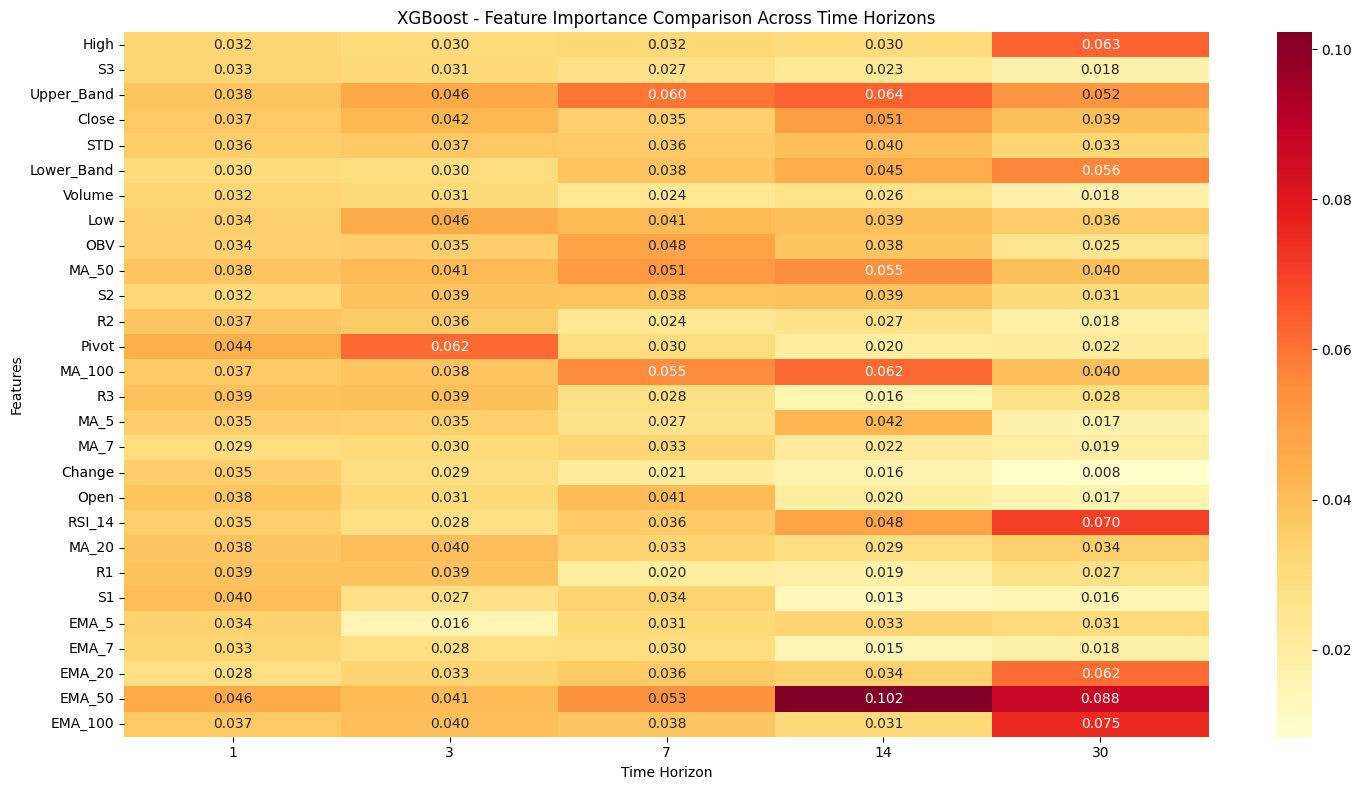

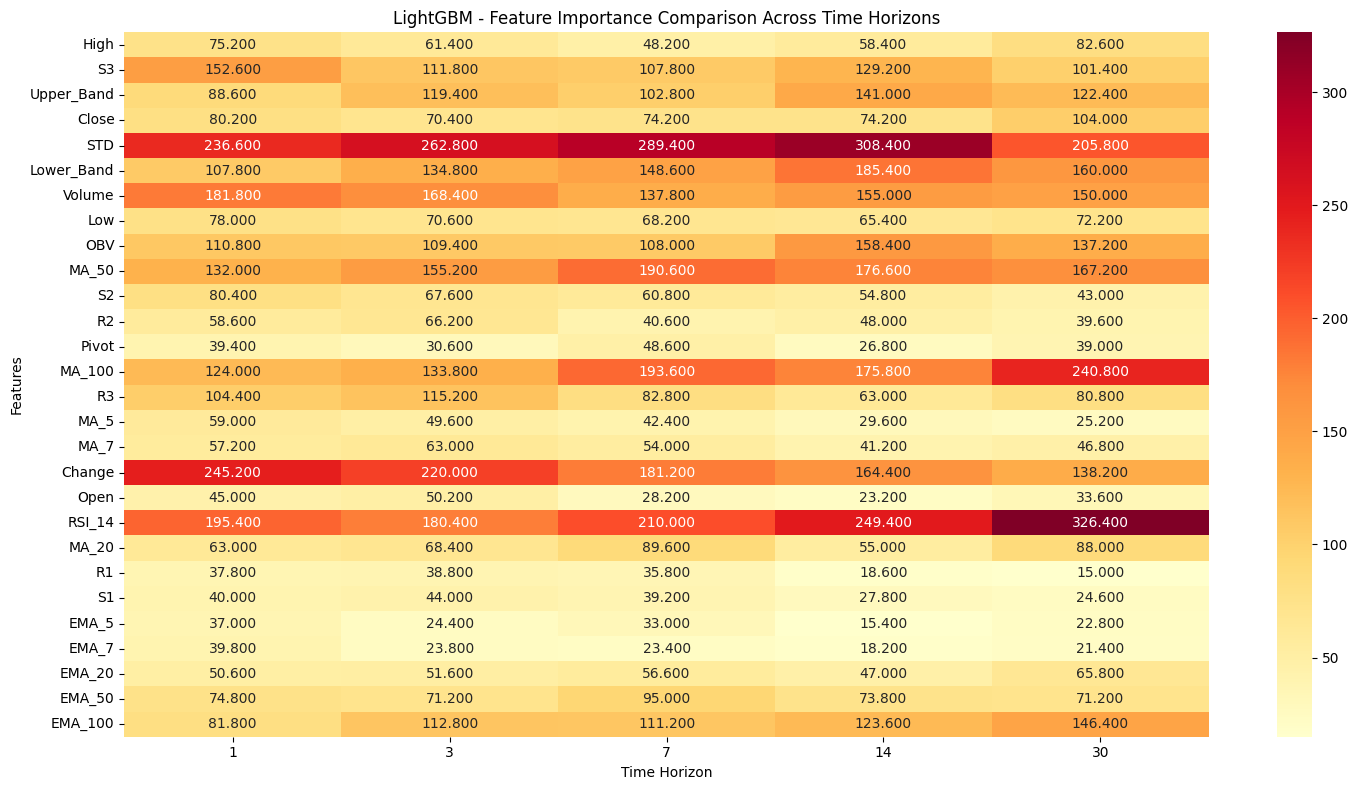

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import Normalizer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# List of forecasting horizons
horizontes = [1, 3, 7, 14, 30]
features = ['High', 'S3', 'Upper_Band', 'Close', 'STD', 'Lower_Band', 'Volume', 'Low', 'OBV', 'MA_50', 'S2', 'R2',
            'Pivot', 'MA_100', 'R3', 'MA_5', 'MA_7', 'Change', 'Open', 'RSI_14', 'MA_20',
            'R1', 'S1', 'EMA_5', 'EMA_7', 'EMA_20', 'EMA_50', 'EMA_100']

# List of models to test
models = {
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, silent=True)
}

# Storage for results and feature importance
all_results = []
feature_importance_dict = {model_name: {} for model_name in models.keys()}

# Initialize the RobustScaler
scaler = Normalizer()

# Loop over each model
for model_name, model_instance in models.items():
    print(f"Evaluating model: {model_name}")

    # Loop over each horizon
    for horizonte in horizontes:
        target_col = f'Direction_t+{horizonte}'

        # Drop NaNs in the current target
        btc_df_h = btc_df.dropna(subset=[target_col])

        # Prepare features and target
        X = btc_df_h[features]
        y = btc_df_h[target_col]

        # Apply RobustScaler to the features
        X_scaled = scaler.fit_transform(X)

        # Initialize TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        # Storage for cross-validation metrics
        metrics = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1 Score': []
        }

        # Storage for feature importance
        feature_importance = np.zeros(len(features))

        # Perform cross-validation
        for train_index, test_index in tscv.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model
            model = model_instance
            model.fit(X_train, y_train)

            # Accumulate feature importance
            if model_name == "XGBoost":
                feature_importance += model.feature_importances_
            else:  # LightGBM
                feature_importance += model.feature_importances_

            # Predict on test data
            y_pred = model.predict(X_test)

            # Calculate performance metrics
            metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['Precision'].append(precision_score(y_test, y_pred))
            metrics['Recall'].append(recall_score(y_test, y_pred))
            metrics['F1 Score'].append(f1_score(y_test, y_pred))

        # Average feature importance for this horizon
        feature_importance = feature_importance / tscv.n_splits
        feature_importance_dict[model_name][horizonte] = feature_importance

        # Average metrics for this horizon
        all_results.append({
            'Model': model_name,
            'Horizonte': f't+{horizonte}',
            'Mean Accuracy': np.mean(metrics['Accuracy']),
            'Mean Precision': np.mean(metrics['Precision']),
            'Mean Recall': np.mean(metrics['Recall']),
            'Mean F1 Score': np.mean(metrics['F1 Score'])
        })

        # Plot confusion matrix for last iteration in cross-validation
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name} at t+{horizonte}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Plot feature importance
        plt.figure(figsize=(15, 6))
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=True)

        plt.barh(range(len(importance_df)), importance_df['Importance'])
        plt.yticks(range(len(importance_df)), importance_df['Feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance for {model_name} at t+{horizonte}')
        plt.tight_layout()
        plt.show()

# Display results as DataFrame for analysis
resultados_df = pd.DataFrame(all_results)
print(resultados_df)

# Plot feature importance comparison across horizons for each model
for model_name in models.keys():
    plt.figure(figsize=(15, 8))
    importance_df = pd.DataFrame(feature_importance_dict[model_name], index=features)
    sns.heatmap(importance_df, cmap='YlOrRd', annot=True, fmt='.3f')
    plt.title(f'{model_name} - Feature Importance Comparison Across Time Horizons')
    plt.xlabel('Time Horizon')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import Normalizer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle  # Para salvar os outputs

# List of forecasting horizons
horizontes = [1, 3, 7, 14, 30]
features = ['High', 'S3', 'Upper_Band', 'Close', 'STD', 'Lower_Band', 'Volume', 'Low', 'OBV', 'MA_50', 'S2', 'R2',
            'Pivot', 'MA_100', 'R3', 'MA_5', 'MA_7', 'Change', 'Open', 'RSI_14', 'MA_20',
            'R1', 'S1', 'EMA_5', 'EMA_7', 'EMA_20', 'EMA_50', 'EMA_100']

# Determine o maior horizonte
max_horizonte = max(horizontes)

# Remova as últimas linhas do dataframe para garantir o mesmo período
btc_df_common = btc_df.iloc[:-max_horizonte]

btc_df_common = btc_df_common[(btc_df_common.index >= '2017-11-21') & (btc_df_common.index <= '2024-01-04')]

output_storage = {model_name: {} for model_name in models.keys()}

# Loop pelos modelos
# Adicione variáveis para armazenar métricas de cada fold
for model_name, model_instance in models.items():
    print(f"Evaluating model: {model_name}")

    for horizonte in horizontes:
        target_col = f'Direction_t+{horizonte}'

        # Ajuste o dataframe para excluir NaNs no alvo atual
        btc_df_h = btc_df_common.dropna(subset=[target_col])

        # Prepare features e target
        X = btc_df_h[features]
        y = btc_df_h[target_col]

        # Normalizar as features
        X_scaled = scaler.fit_transform(X)

        # Inicialize TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        # Variáveis para rastrear o melhor fold
        best_fold_score = 0
        best_y_pred = None
        best_y_proba = None
        best_y_test = None

        for fold, (train_index, test_index) in enumerate(tscv.split(X_scaled), 1):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Treine o modelo
            model = model_instance
            model.fit(X_train, y_train)

            # Predições e avaliação
            y_pred = model.predict(X_test)

            # Escolha uma métrica para avaliar o melhor fold
            # Exemplo usando accuracy, mas você pode mudar para f1, precision, etc.
            fold_score = accuracy_score(y_test, y_pred)

            # Atualizar o melhor fold
            if fold_score > best_fold_score:
                best_fold_score = fold_score
                best_y_pred = y_pred
                best_y_test = y_test

                # Adicionar probabilidades se disponível
                if hasattr(model, "predict_proba"):
                    best_y_proba = model.predict_proba(X_test)[:, 1]
                else:
                    best_y_proba = None

        # Armazene os resultados do melhor fold
        output_storage[model_name][f't+{horizonte}'] = {
            'predictions': best_y_pred,
            'probabilities': best_y_proba,
            'actuals': best_y_test,
            'best_fold_score': best_fold_score
        }

# Save the outputs for later use in the meta-model
with open('model_outputs_tech.pkl', 'wb') as f:
    pickle.dump(output_storage, f)

print("Model outputs saved successfully!")


Evaluating model: XGBoost
Evaluating model: LightGBM
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 180, number of negative: 193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3510
[LightGBM] [Info] Number of data points in the train set: 373, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482574 -> initscore=-0.069733
[LightGBM] [Info] Start training from score -0.069733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [37]:
output_storage['XGBoost']['t+1']['predictions'].shape

(372,)

In [25]:
feature_importance_dict

{'XGBoost': {1: array([0.03240329, 0.03276351, 0.03825191, 0.03671713, 0.0355091 ,
         0.03009435, 0.03234449, 0.0344775 , 0.03415243, 0.03757033,
         0.03163914, 0.03738997, 0.04401602, 0.03663608, 0.03893067,
         0.03545839, 0.02934892, 0.03527322, 0.03805094, 0.0349386 ,
         0.03761373, 0.03877937, 0.03968874, 0.03382962, 0.03279559,
         0.02824514, 0.04595599, 0.03712583]),
  3: array([0.03015084, 0.03146494, 0.04624881, 0.04194945, 0.03666931,
         0.0297723 , 0.03111695, 0.04607647, 0.03518961, 0.04131087,
         0.03863401, 0.03592408, 0.06179429, 0.03811058, 0.03929893,
         0.03455117, 0.03040787, 0.02868908, 0.03137545, 0.02782698,
         0.03970626, 0.0386016 , 0.02724965, 0.01561896, 0.02827124,
         0.03325567, 0.04093035, 0.03980428]),
  7: array([0.03223253, 0.02730774, 0.05991385, 0.03481152, 0.03591948,
         0.03825742, 0.02377562, 0.04107961, 0.04800562, 0.05107442,
         0.03821583, 0.02395031, 0.02952448, 0.05546267, 0

In [26]:
importance_df

,1,3,7,14,30
High,75.2,61.4,48.2,58.4,82.6
S3,152.6,111.8,107.8,129.2,101.4
Upper_Band,88.6,119.4,102.8,141.0,122.4
Close,80.2,70.4,74.2,74.2,104.0
STD,236.6,262.8,289.4,308.4,205.8
Lower_Band,107.8,134.8,148.6,185.4,160.0
Volume,181.8,168.4,137.8,155.0,150.0
Low,78.0,70.6,68.2,65.4,72.2
OBV,110.8,109.4,108.0,158.4,137.2
MA_50,132.0,155.2,190.6,176.6,167.2


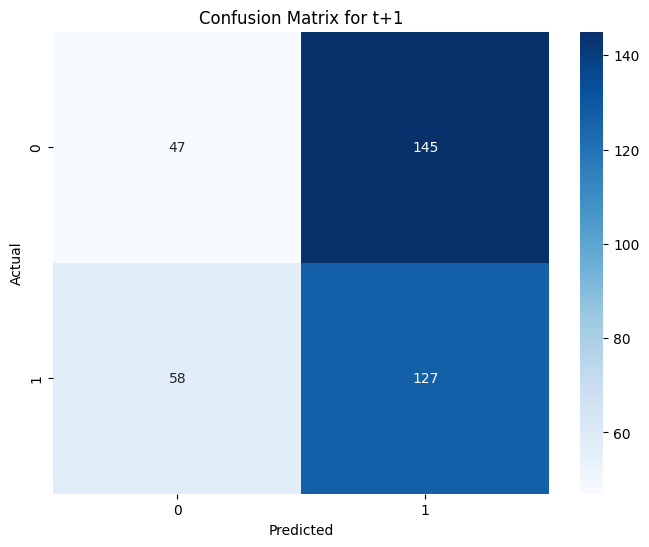

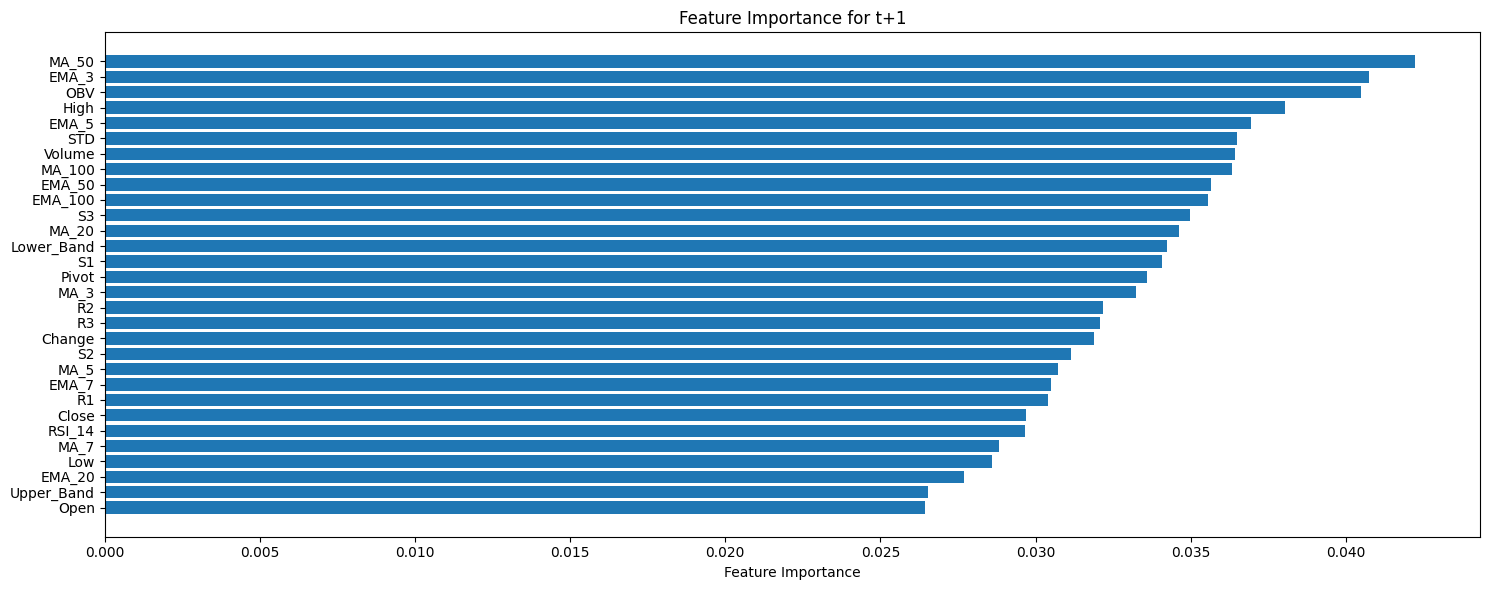

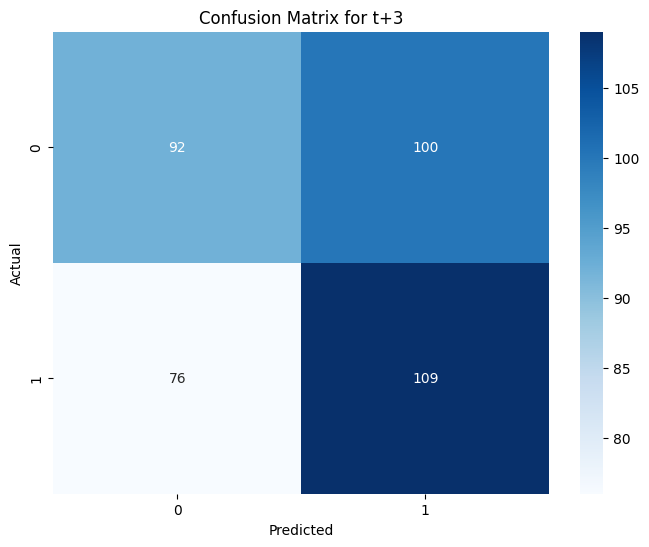

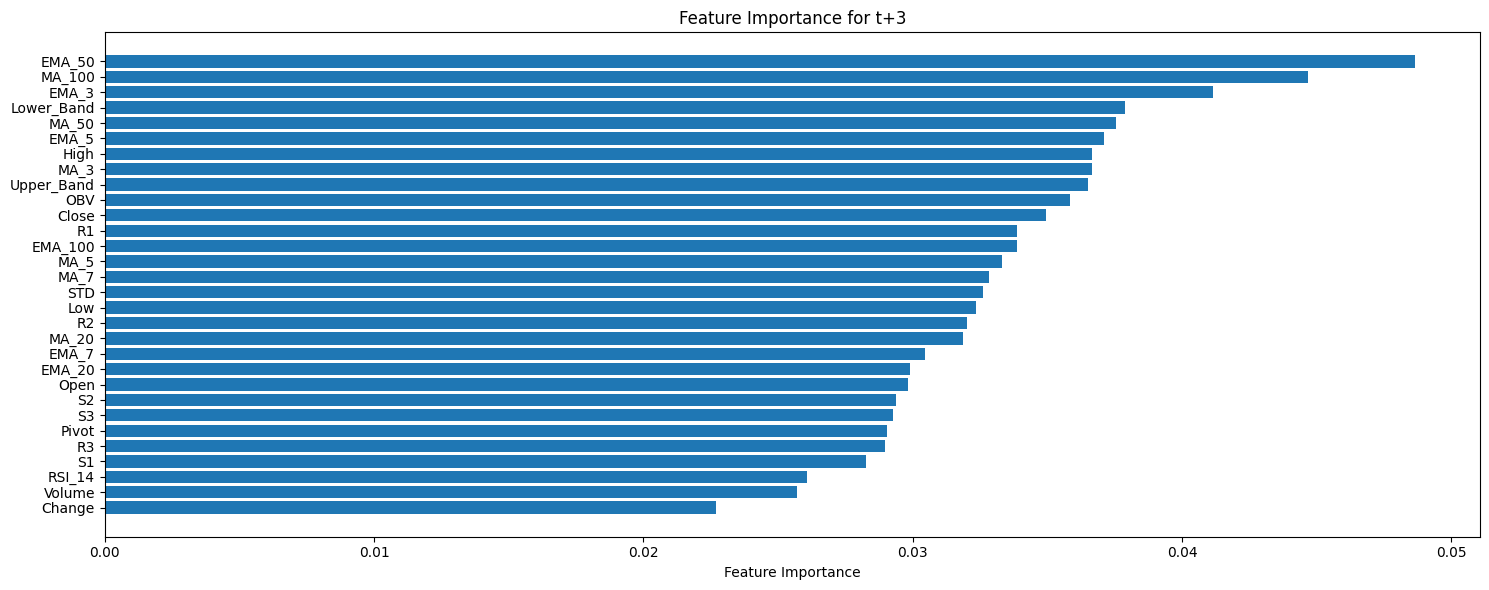

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


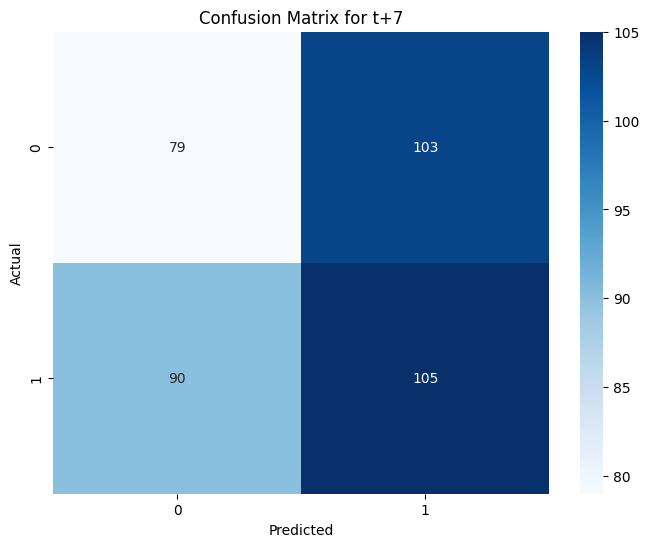

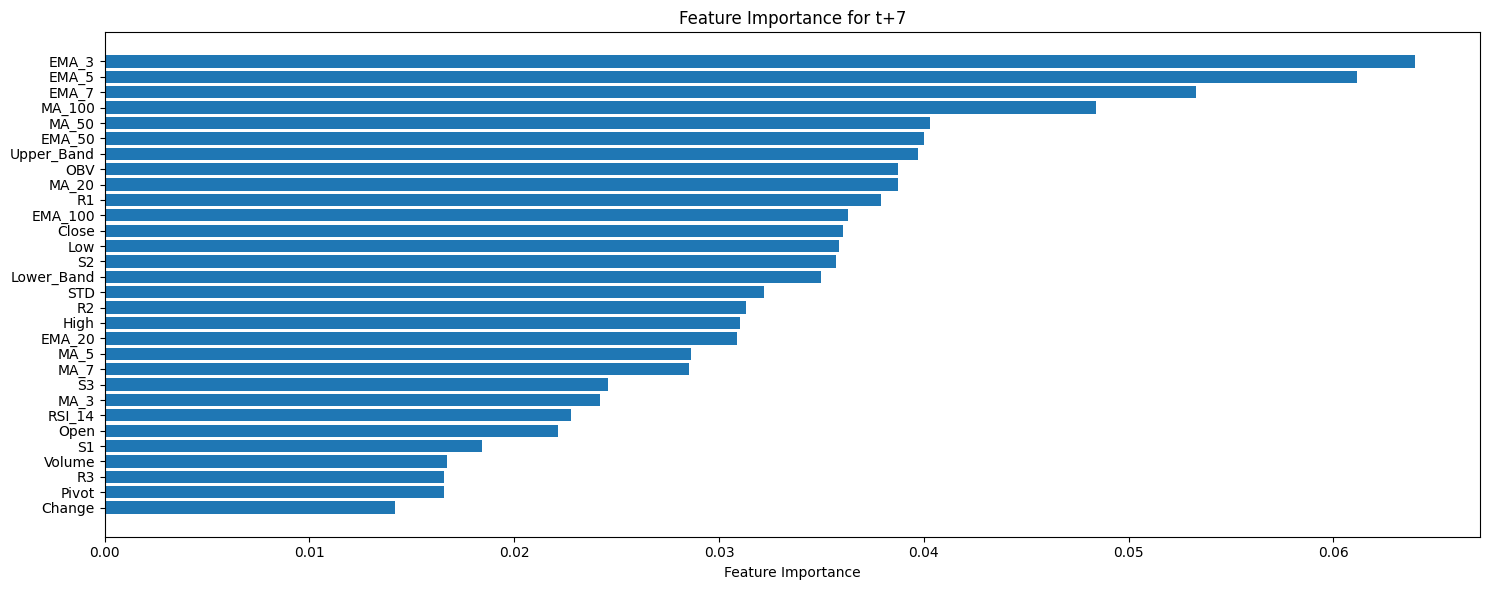

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


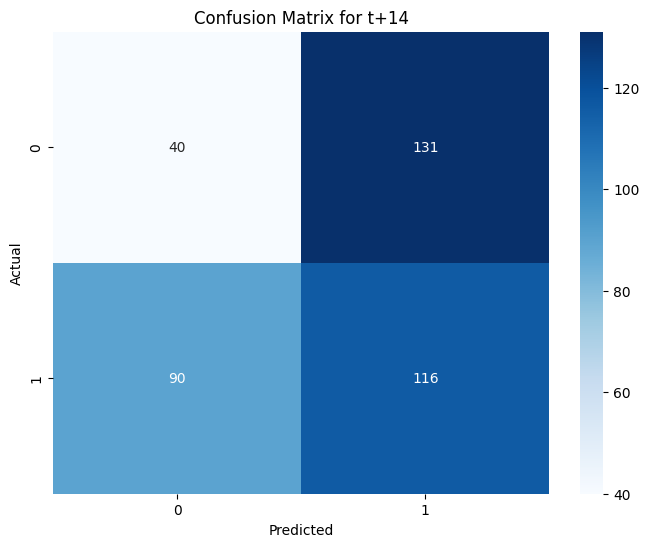

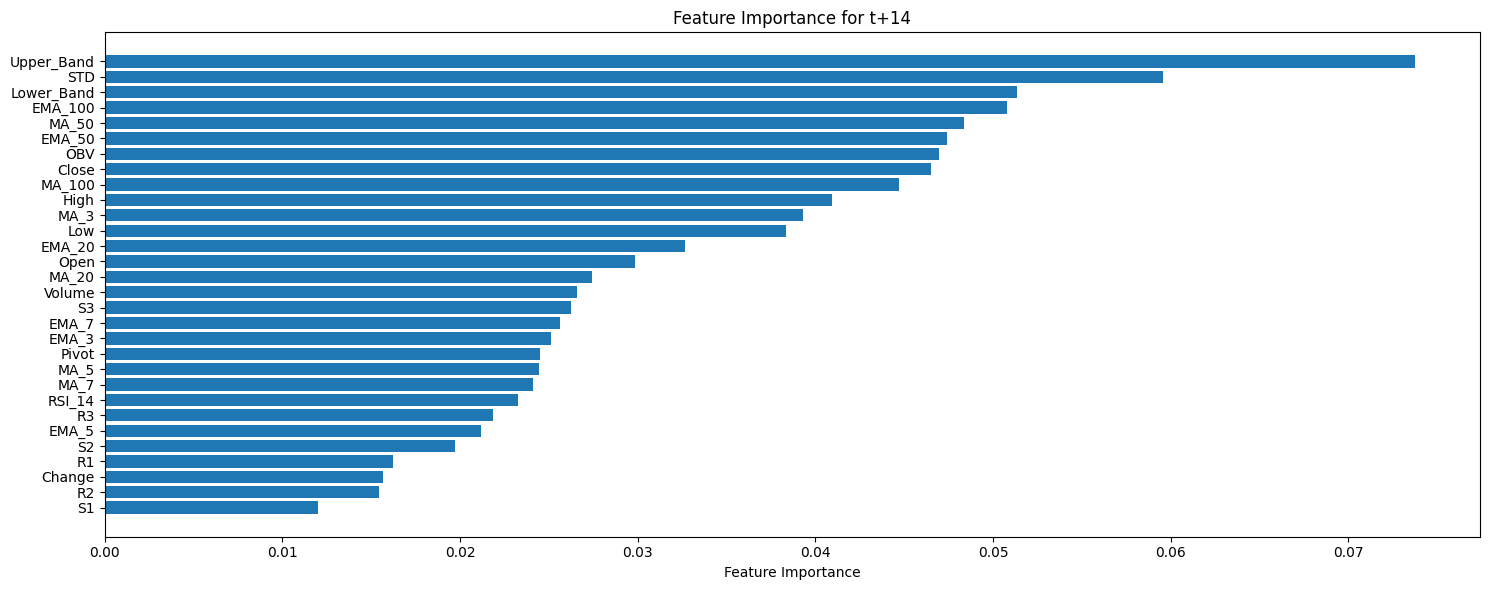

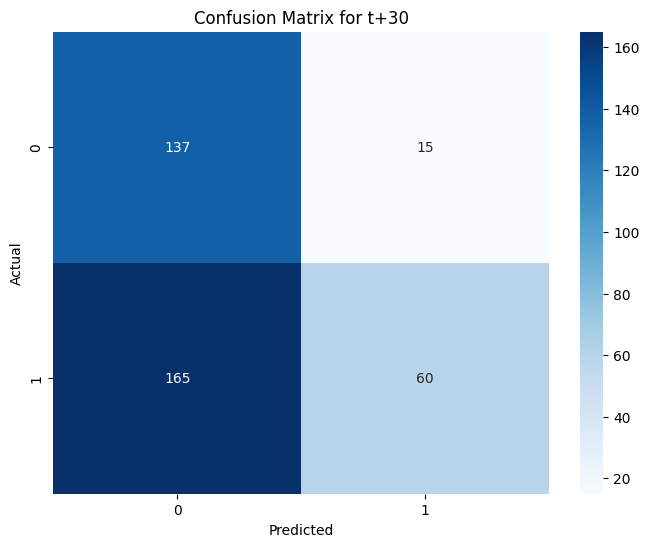

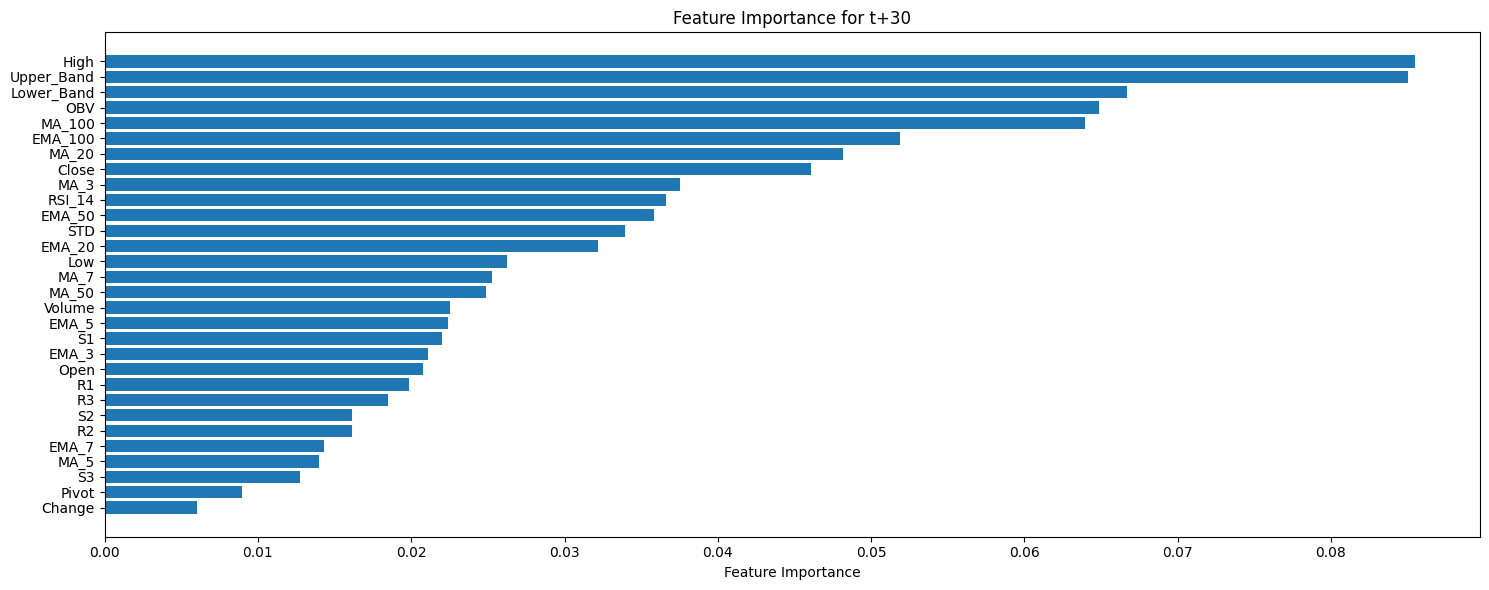

  Horizonte  Mean Accuracy  Mean Precision  Mean Recall  Mean F1 Score
0       t+1       0.496021        0.593135     0.373224       0.376263
1       t+3       0.502387        0.619956     0.378644       0.378189
2       t+7       0.472149        0.483638     0.390813       0.345209
3      t+14       0.461008        0.521670     0.417060       0.356729
4      t+30       0.451989        0.712817     0.338689       0.338338


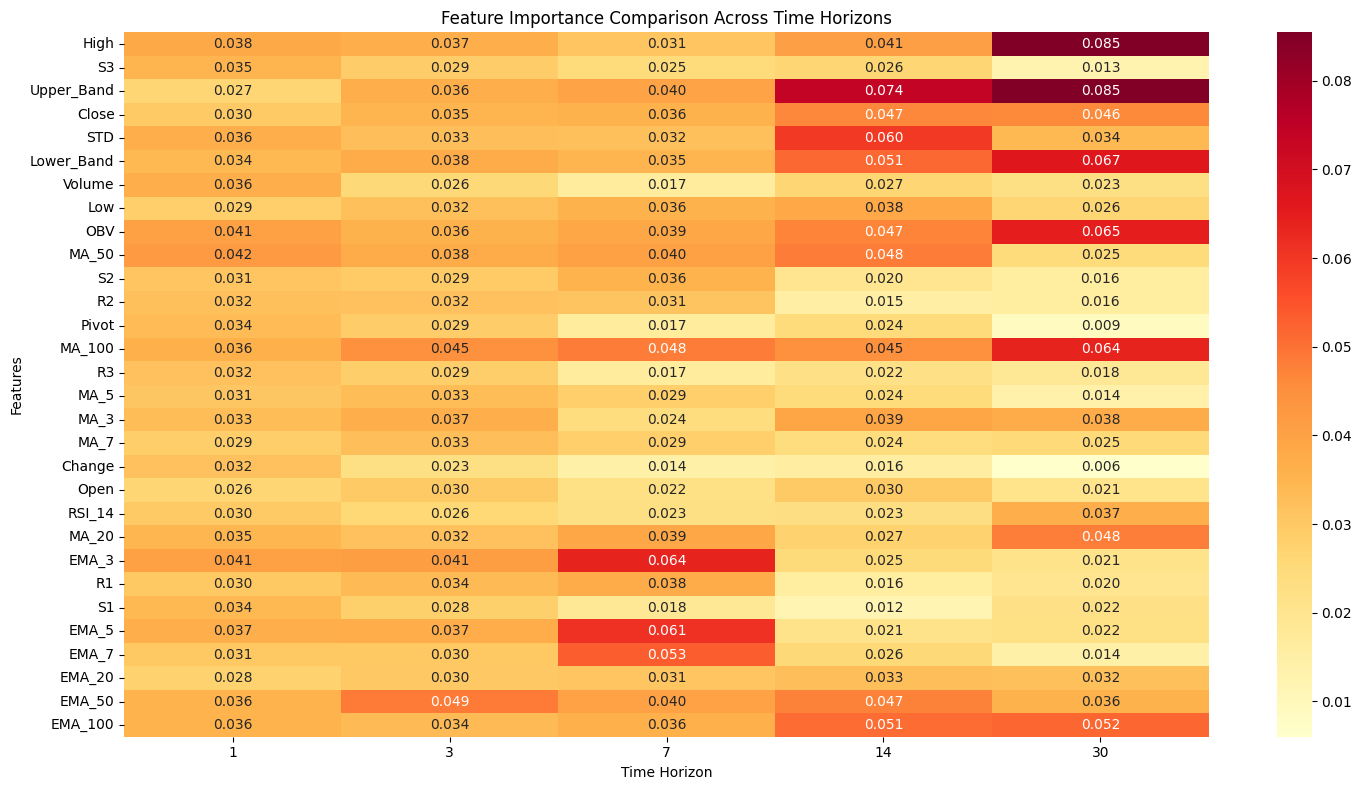

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de horizontes para avaliação
horizontes = [1, 3, 7, 14, 30]
features = ['High', 'S3', 'Upper_Band', 'Close', 'STD', 'Lower_Band', 'Volume', 'Low', 'OBV', 'MA_50', 'S2', 'R2', 'Pivot', 'MA_100', 'R3', 'MA_5',
            'MA_3', 'MA_7', 'Change', 'Open', 'RSI_14', 'MA_20', 'EMA_3', 'R1', 'S1','EMA_5', 'EMA_7', 'EMA_20',
            'EMA_50', 'EMA_100']

# Armazenar métricas para cada horizonte
resultados = []
feature_importance_dict = {}

# Loop para cada horizonte
for horizonte in horizontes:
    target_col = f'Direction_t+{horizonte}'

    # Remova as linhas com NaN no target atual
    btc_df_h = btc_df.dropna(subset=[target_col])

    # Prepare features e target
    X = btc_df_h[features]
    y = btc_df_h[target_col]

    # Inicialize o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Armazenar métricas para a validação cruzada
    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }

    # Armazenar importância das features para este horizonte
    feature_importance = np.zeros(len(features))

    # Realizar a validação cruzada
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Inicialize e treine o modelo
        model = XGBClassifier(random_state=42)
        model.fit(X_train, y_train)

        # Acumular feature importance
        feature_importance += model.feature_importances_

        # Faça previsões
        y_pred = model.predict(X_test)

        # Calcule as métricas de desempenho
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Armazene as métricas
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1 Score'].append(f1)

    # Média da feature importance para este horizonte
    feature_importance = feature_importance / tscv.n_splits
    feature_importance_dict[horizonte] = feature_importance

    # Calcule a média das métricas para este horizonte
    resultados.append({
        'Horizonte': f't+{horizonte}',
        'Mean Accuracy': np.mean(metrics['Accuracy']),
        'Mean Precision': np.mean(metrics['Precision']),
        'Mean Recall': np.mean(metrics['Recall']),
        'Mean F1 Score': np.mean(metrics['F1 Score'])
    })

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for t+{horizonte}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 6))
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=True)

    plt.barh(range(len(importance_df)), importance_df['Importance'])
    plt.yticks(range(len(importance_df)), importance_df['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for t+{horizonte}')
    plt.tight_layout()
    plt.show()

# Exibir resultados como DataFrame para análise
resultados_df = pd.DataFrame(resultados)
print(resultados_df)

# Plot feature importance comparison across horizons
plt.figure(figsize=(15, 8))
importance_df = pd.DataFrame(feature_importance_dict, index=features)
sns.heatmap(importance_df, cmap='YlOrRd', annot=True, fmt='.3f')
plt.title('Feature Importance Comparison Across Time Horizons')
plt.xlabel('Time Horizon')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

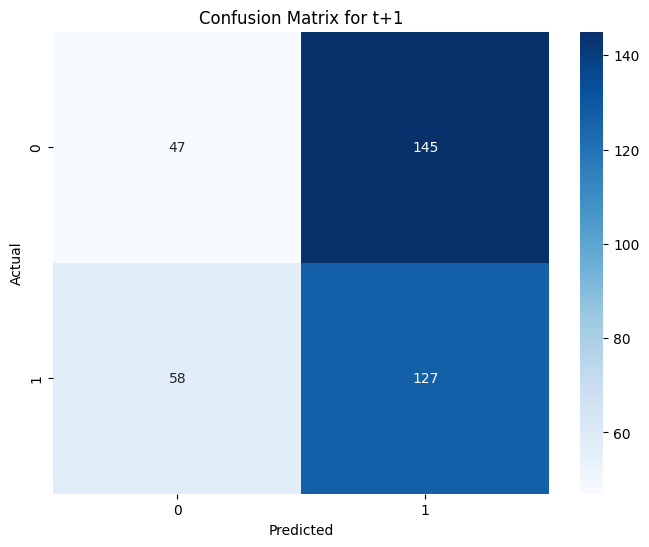

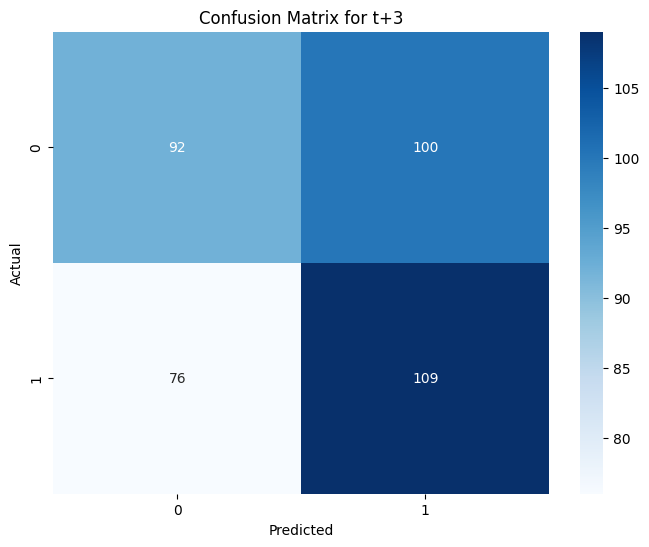

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


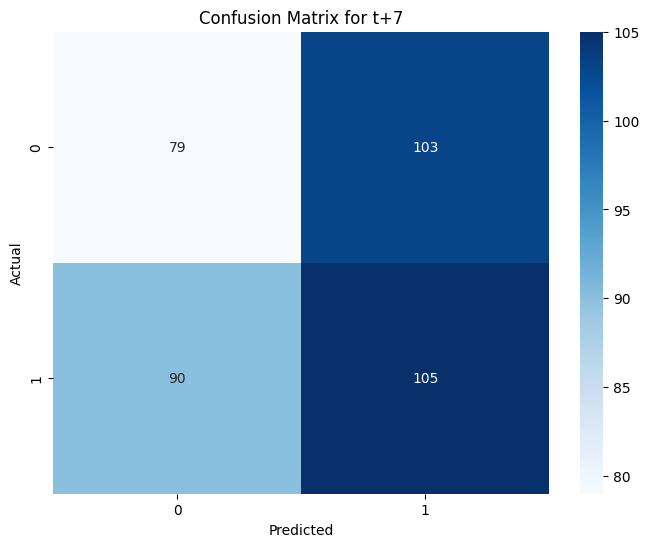

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


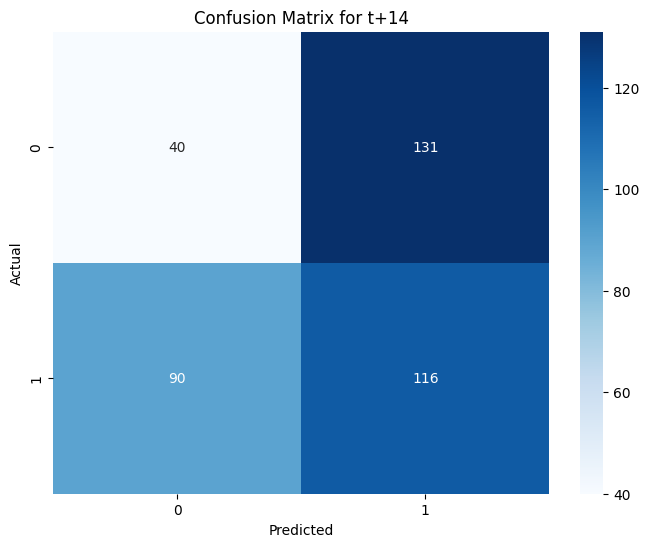

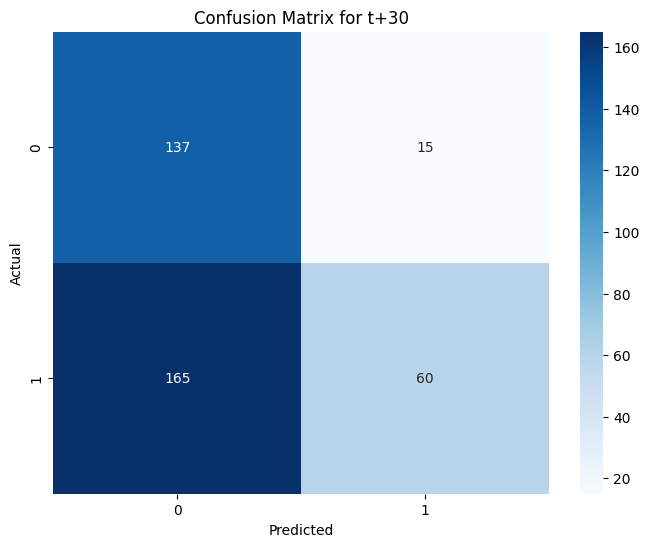

  Horizonte  Mean Accuracy  Mean Precision  Mean Recall  Mean F1 Score
0       t+1       0.496021        0.593135     0.373224       0.376263
1       t+3       0.502387        0.619956     0.378644       0.378189
2       t+7       0.472149        0.483638     0.390813       0.345209
3      t+14       0.461008        0.521670     0.417060       0.356729
4      t+30       0.451989        0.712817     0.338689       0.338338


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de horizontes para avaliação
horizontes = [1, 3, 7, 14, 30]
features = ['High', 'S3', 'Upper_Band', 'Close', 'STD', 'Lower_Band', 'Volume', 'Low', 'OBV', 'MA_50', 'S2', 'R2', 'Pivot', 'MA_100', 'R3', 'MA_5',
            'MA_3', 'MA_7', 'Change', 'Open', 'RSI_14', 'MA_20', 'EMA_3', 'R1', 'S1','EMA_5', 'EMA_7', 'EMA_20',
            'EMA_50', 'EMA_100']

# Armazenar métricas para cada horizonte
resultados = []

# Loop para cada horizonte
for horizonte in horizontes:
    target_col = f'Direction_t+{horizonte}'

    # Remova as linhas com NaN no target atual
    btc_df_h = btc_df.dropna(subset=[target_col])

    # Prepare features e target
    X = btc_df_h[features]
    y = btc_df_h[target_col]

    # Inicialize o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Armazenar métricas para a validação cruzada
    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }

    # Realizar a validação cruzada
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Inicialize e treine o modelo
        model = XGBClassifier(random_state=42)
        model.fit(X_train, y_train)

        # Faça previsões
        y_pred = model.predict(X_test)

        # Calcule as métricas de desempenho
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Armazene as métricas
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1 Score'].append(f1)

    # Calcule a média das métricas para este horizonte
    resultados.append({
        'Horizonte': f't+{horizonte}',
        'Mean Accuracy': np.mean(metrics['Accuracy']),
        'Mean Precision': np.mean(metrics['Precision']),
        'Mean Recall': np.mean(metrics['Recall']),
        'Mean F1 Score': np.mean(metrics['F1 Score'])
    })

    # Exiba a matriz de confusão da última iteração
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for t+{horizonte}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Exibir resultados como DataFrame para análise
resultados_df = pd.DataFrame(resultados)
print(resultados_df)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average Accuracy: 0.5231
Average Precision: 0.5573
Average Recall: 0.5082
Average F1 Score: 0.5042


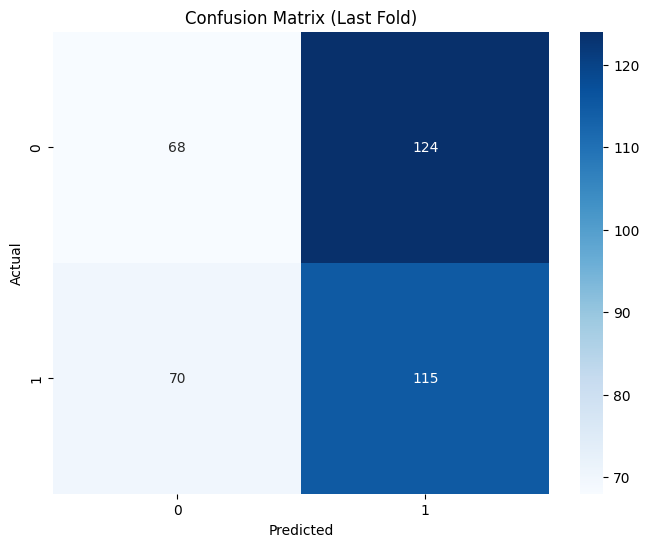

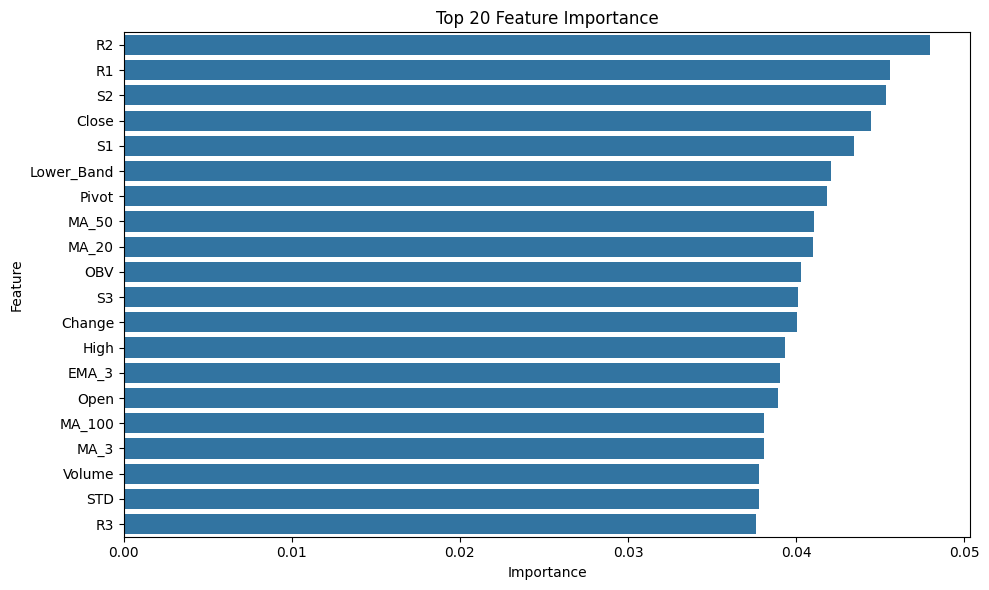

Best hyperparameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming btc_df is already loaded and preprocessed
btc_df = btc_df.dropna()



# Drop NaN values created by lag features
btc_df = btc_df.dropna()

features = ['High', 'S3', 'Upper_Band', 'Close', 'STD', 'Lower_Band', 'Volume', 'Low', 'OBV', 'MA_50', 'S2', 'R2', 'Pivot', 'MA_100', 'R3', 'MA_5',
            'MA_3', 'MA_7', 'Change', 'Open', 'RSI_14', 'MA_20', 'EMA_3', 'R1', 'S1']

# Prepare features and target
X = btc_df[features]
y = btc_df['Direction_t+1']

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize StandardScaler
scaler = StandardScaler()

# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize XGBoost classifier
model = XGBClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=100, cv=tscv, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
X_scaled = scaler.fit_transform(X)
random_search.fit(X_scaled, y)

# Get the best model
best_model = random_search.best_estimator_

# Initialize lists to store performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Perform time series cross-validation with the best model
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    best_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)

    # Calculate and store performance metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Print average metrics
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")

# Create and plot confusion matrix (using the last fold for illustration)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Last Fold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
feature_importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Best hyperparameters:", random_search.best_params_)

In [30]:
feature_importance_df['feature'].to_list()

['R2',
 'R1',
 'S2',
 'Close',
 'S1',
 'Lower_Band',
 'Pivot',
 'MA_50',
 'MA_20',
 'OBV',
 'S3',
 'Change',
 'High',
 'EMA_3',
 'Open',
 'MA_100',
 'MA_3',
 'Volume',
 'STD',
 'R3',
 'Low',
 'RSI_14',
 'Upper_Band',
 'MA_7',
 'MA_5']